In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import definitive_dyn_indicators.scripts.data_manager as dm
import os
from tqdm.auto import tqdm
from numba import njit
import lmfit
import joblib
from joblib import Parallel, delayed

In [2]:
njobs = os.cpu_count()

In [3]:
njobs

20

# 0 - General setup

Remote Dir

In [ ]:
data = dm.data_manager(
    data_dir="/eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/dynamic_indicator_analysis/big_data")

Local Dir

In [4]:
data = dm.data_manager()

Setup config and get times

In [5]:
config = data.get_config()
print(list(config.keys()))
extents = config["x_extents"] + config["y_extents"]
samples = config["samples"]
print(samples)

['name', 'samples', 'random_seed', 'displacement_scale', 'x_extents', 'y_extents', 'low_tracking', 'tracking', 'extreme_tracking', 't_base_10', 't_base_2', 't_linear', 't_base', 'barrier', 't_list', 't_diff', 'x_sample', 'dx', 'y_sample', 'dy', 'xx', 'yy', 'x_flat', 'y_flat', 'px_flat', 'py_flat', 'total_samples', 'displacement', 'x_random_displacement', 'y_random_displacement', 'px_random_displacement', 'py_random_displacement', 'x_displacement', 'y_displacement', 'px_displacement', 'py_displacement']
100


In [6]:
times = np.asarray(data.get_times())
all_times = times.copy()
low_times = times[times <= 1000]
high_times = times[times >= 1000]
good_times = np.unique(np.concatenate([config["t_base_10"], config["t_base_2"], config["t_linear"]]))
#########################
good_times = times.copy()
#########################
good_times_2 = config["t_base_10"]
low_times_2 = good_times_2[good_times_2 <= 1000]
#########################
print(times)
print(len(times))

[      1       2       3 ...  999000 1000000 1048576]
2037


In [7]:
len(low_times)

1000

### Loading up specific group of datasets

In [8]:
group = (0.168, 0.201, 'sps', 16.0, -0.01, np.nan, np.nan)
group_name = f"$\\epsilon={group[3]}, \\mu={group[4]}$"

In [9]:
group_rand = (0.168, 0.201, 'sps', 16.0, -0.01, 1e-6, np.nan)

In [9]:
group = data.get_groups()[0]
print(group)

group_name = f"$\\epsilon={group[3]}, \\mu={group[4]}$"
print(group_name)

TypeError: 'set' object is not subscriptable

### Visualizing the sample

In [10]:
stability = data.stability(group)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking track!


In [16]:
fft_tunes = data.fft_tunes(group, time_tresh=None)
fft_tunes_low = data.fft_tunes(group, time_tresh=1500)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking fft_tunes!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking fft_tunes!


In [17]:
birkhoff_tunes = data.birkhoff_tunes(group, time_tresh=None)
birkhoff_tunes_low = data.birkhoff_tunes(group, time_tresh=1500)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking birkhoff_tunes!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking birkhoff_tunes!


In [13]:
birkhoff_tunes_low

2         4         8         16        32        64        128   \
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.001433  0.001213  0.000716  0.000152  0.000297  0.000326  0.000393   
2     0.002877  0.002401  0.001383  0.000137  0.000297  0.000326  0.000393   
3     0.004327  0.003579  0.002052  0.000123  0.000298  0.000326  0.000393   
4     0.005786  0.004747  0.002724  0.000108  0.000299  0.000326  0.000393   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.731560       NaN       NaN       NaN       NaN       NaN       NaN   
9996  0.725798  0.628591       NaN       NaN       NaN       NaN       NaN   
9997  0.720426       NaN       NaN       NaN       NaN       NaN       NaN   
9998  0.715356  0.624302       NaN       NaN       NaN       NaN       NaN   
9999  0.710614  0.637617       NaN       NaN       NaN       NaN       NaN   

          256       512       1024  
0     0.000000  0.000000  0.000000  
1     0.000304  0.000211  0.000147  
2     0.000304  0.000211  0.000147  
3     0.000304  0.000211  0.000147  
4     0.000304  0.000211  0.000147  
...        ...       ...       ...  
9995       NaN       NaN       NaN  
9996       NaN       NaN       NaN  
9997       NaN       NaN       NaN  
9998       NaN       NaN       NaN  
9999       NaN       NaN       NaN  

[10000 rows x 10 columns]

In [18]:
tangent_map = data.tangent_map(group, times=good_times)
tangent_map_low = data.tangent_map(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking tangent_map!


100%|██████████| 2037/2037 [00:03<00:00, 626.58it/s] 


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking tangent_map!


100%|██████████| 1000/1000 [00:00<00:00, 1221.90it/s]


In [11]:
lyapunov = data.fast_lyapunov_indicator(group, times=good_times)
lyapunov_low = data.fast_lyapunov_indicator(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 2037/2037 [00:21<00:00, 95.90it/s] 


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 1000/1000 [00:02<00:00, 385.16it/s]


In [12]:
better_lyapunov = data.better_lyapunov(group, times=good_times)
better_lyapunov_low = data.better_lyapunov(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking true_displacement!
Generating (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) on the fly
Loading data...
Instatiating engine...
CUDA devices available: 4
Elapsed time: 0:02:15.820582
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking true_displacement!


100%|██████████| 2037/2037 [00:01<00:00, 1803.16it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking true_displacement!


100%|██████████| 1000/1000 [00:00<00:00, 1724.52it/s]


In [20]:
raw_displacement = data.raw_displacement(group, times=good_times)
raw_displacement_low = data.raw_displacement(group, times=low_times) 

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 2037/2037 [00:05<00:00, 394.66it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement random and tracking step_track!


100%|██████████| 1000/1000 [00:02<00:00, 396.10it/s]


In [21]:
lyapunov_multi = data.invariant_lyapunov_indicator(group, times=good_times)
lyapunov_multi_low = data.invariant_lyapunov_indicator(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 2037/2037 [00:44<00:00, 46.08it/s] 


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 1000/1000 [00:07<00:00, 132.93it/s]


In [22]:
reverse = data.reversibility_error(group, times=good_times)
reverse_low = data.reversibility_error(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 2037/2037 [00:10<00:00, 203.68it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 1000/1000 [00:01<00:00, 787.70it/s]


In [23]:
reverse_rand = data.reversibility_error(group_rand, times=good_times)
reverse_rand_low = data.reversibility_error(group_rand, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, 1e-06, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 2037/2037 [00:09<00:00, 206.14it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, 1e-06, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 1000/1000 [00:01<00:00, 801.02it/s]


In [24]:
megno = data.megno(group, times=good_times)
megno_low = data.megno(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking megno!


100%|██████████| 2037/2037 [00:02<00:00, 891.73it/s] 


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking megno!


100%|██████████| 1000/1000 [00:00<00:00, 2800.69it/s]


In [25]:
sali = data.smallest_alignment_index(group, times=good_times)
sali_low = data.smallest_alignment_index(group, times=low_times)
gali = data.global_alignment_index(group, times=good_times)
gali_low = data.global_alignment_index(group, times=low_times)

Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!


100%|██████████| 2037/2037 [00:08<00:00, 230.77it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!


100%|██████████| 1000/1000 [00:04<00:00, 238.86it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 2037/2037 [00:54<00:00, 37.34it/s]


Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement none and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement x and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement y and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement px and tracking step_track!
Getting file for group (0.168, 0.201, 'sps', 16.0, -0.01, nan, nan) with displacement py and tracking step_track!


100%|██████████| 1000/1000 [00:32<00:00, 30.60it/s]


In [13]:
radius = data.initial_radius()

 ### Execute this cell if you want to perform the downsampling

In [10]:
ds_step = 5

In [19]:
raw_displacement = dm.apply_downsample_to_dataset(raw_displacement, step=ds_step)
megno = dm.apply_downsample_to_dataset(megno, step=ds_step)
sali = dm.apply_downsample_to_dataset(sali, step=ds_step)
gali = dm.apply_downsample_to_dataset(gali, step=ds_step)


100%|██████████| 71/71 [00:00<00:00, 2793.58it/s]


In [18]:
reverse = dm.apply_downsample_to_dataset(reverse, step=ds_step)

100%|██████████| 71/71 [00:00<00:00, 1501.58it/s]


In [13]:
radius = dm.downsample(radius, step=ds_step)

In [14]:
stability = dm.downsample(stability, step=ds_step)
lyapunov = dm.apply_downsample_to_dataset(lyapunov, step=ds_step)

100%|██████████| 71/71 [00:00<00:00, 1671.26it/s]


In [15]:
extents = config["x_extents"] + config["y_extents"]
samples = config["samples"]//ds_step
print(samples)

200


### visualising the sample

/tmp/ipykernel_9797/1966436047.py:28: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[val].to_numpy()).reshape(samples, samples),


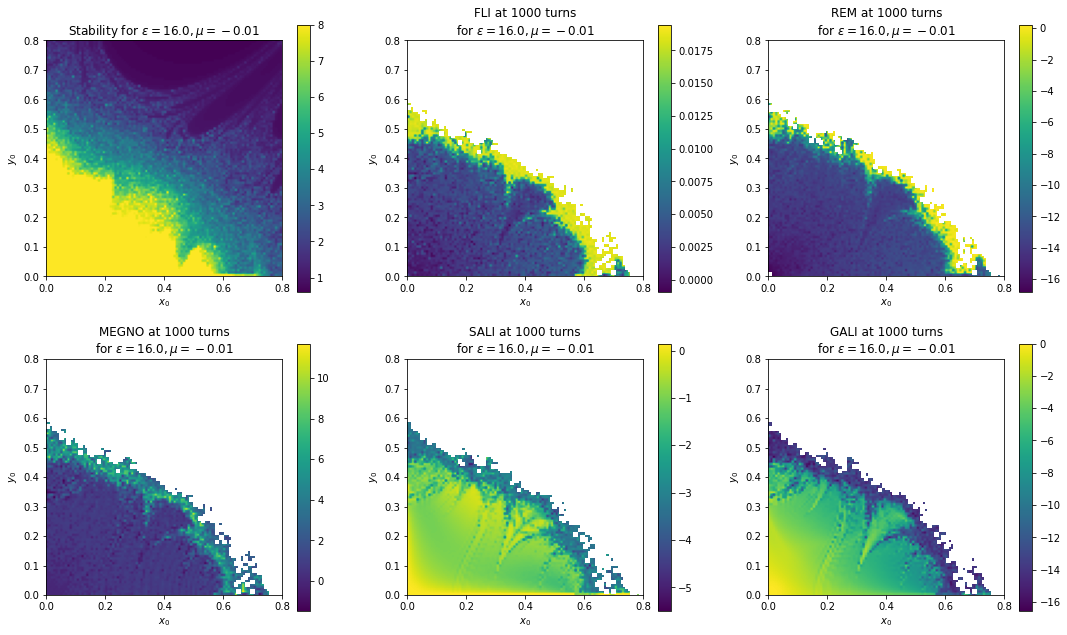

In [23]:
val = 1000

fig, axs = plt.subplots(2, 3, figsize=(15, 9))

im_00 = axs[0][0].imshow(
    np.log10(stability.reshape(samples, samples)),
    origin="lower",
    extent=extents,
)
# set colorbar for im_00
fig.colorbar(im_00, ax=axs[0][0])
axs[0][0].set_title(f"Stability for {group_name}")
axs[0][0].set_xlabel("$x_0$")
axs[0][0].set_ylabel("$y_0$")

im_01 = axs[0][1].imshow(
    lyapunov[val].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_01
fig.colorbar(im_01, ax=axs[0][1])
axs[0][1].set_title(f"FLI at {val} turns\nfor {group_name}")
axs[0][1].set_xlabel("$x_0$")
axs[0][1].set_ylabel("$y_0$")

im_02 = axs[0][2].imshow(
    np.log10(reverse[val].to_numpy()).reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_02
fig.colorbar(im_02, ax=axs[0][2])
axs[0][2].set_title(f"REM at {val} turns\nfor {group_name}")
axs[0][2].set_xlabel("$x_0$")
axs[0][2].set_ylabel("$y_0$")

im_10 = axs[1][0].imshow(
    megno[val].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_10
fig.colorbar(im_10, ax=axs[1][0])
axs[1][0].set_title(f"MEGNO at {val} turns\nfor {group_name}")
axs[1][0].set_xlabel("$x_0$")
axs[1][0].set_ylabel("$y_0$")

im_11 = axs[1][1].imshow(
    np.log10(sali[val].to_numpy()).reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_11
fig.colorbar(im_11, ax=axs[1][1])
axs[1][1].set_title(f"SALI at {val} turns\nfor {group_name}")
axs[1][1].set_xlabel("$x_0$")
axs[1][1].set_ylabel("$y_0$")

im_12 = axs[1][2].imshow(
    np.log10(gali[val].to_numpy()).reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_12
fig.colorbar(im_12, ax=axs[1][2])
axs[1][2].set_title(f"GALI at {val} turns\nfor {group_name}")
axs[1][2].set_xlabel("$x_0$")
axs[1][2].set_ylabel("$y_0$")

plt.tight_layout()

In [137]:
# get column names of tangent_map
tangent_map_columns = tangent_map.columns
tangent_map_columns

Int64Index([      1,       2,       3,       4,       5,       6,       7,
                  8,       9,      10,
            ...
             992000,  993000,  994000,  995000,  996000,  997000,  998000,
             999000, 1000000, 1048576],
           dtype='int64', length=2037)

In [141]:
tangent_map[10000].to_numpy()

array([3.01029996e-05, 3.09823207e-05, 4.07482097e-05, ...,
                  nan,            nan,            nan])

/tmp/ipykernel_3992/3340313259.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(better_lyapunov[10000].to_numpy()).reshape(100, 100),


Text(0.5, 1.0, 'tangent map')

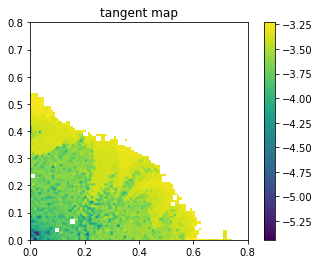

In [13]:
plt.imshow(
    np.log10(tangent_map[10000].to_numpy()).reshape(100, 100),
    origin="lower",
    extent=extents,
)
plt.colorbar()
plt.title("tangent map")

Text(0.5, 1.0, 'tangent map')

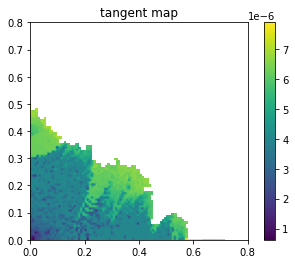

In [15]:
plt.imshow(
    (better_lyapunov[1000000].to_numpy()).reshape(100, 100),
    origin="lower",
    extent=extents,
)
plt.colorbar()
plt.title("tangent map")

# 1 - Chaos analysis

## 1.0 - Defining a "Golden Standard" for Chaos measurement

We recall the formula for the Fast Lyapunov Indicator computed after $n$ iterations of the map $M$:

$$
FLI_n(\mathbf{x}_0) = \frac{\ln\frac{|M^n(\mathbf{x}) - M^n(\mathbf{x} + \epsilon \mathbf{\hat{e}})|}{\epsilon}}{n}
$$

Let's consider two iteration times $n_1 = 10^3$ and $n_2 = 10^5$ and the corresponding values obtained by FLI

In [25]:
t1 = 100
t2 = 100000

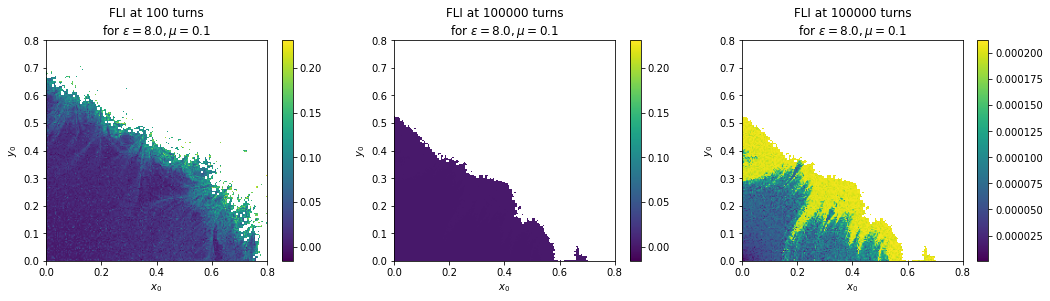

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im_0 = axs[0].imshow(
    lyapunov[t1].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_0
fig.colorbar(im_0, ax=axs[0])
axs[0].set_title(f"FLI at {t1} turns\nfor {group_name}")
axs[0].set_xlabel("$x_0$")
axs[0].set_ylabel("$y_0$")

# use the same colorbar for im_1
im_1 = axs[1].imshow(
    lyapunov[t2].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
    vmin=im_0.get_clim()[0],
    vmax=im_0.get_clim()[1],
)
# set colorbar for im_1
fig.colorbar(im_1, ax=axs[1])
axs[1].set_title(f"FLI at {t2} turns\nfor {group_name}")
axs[1].set_xlabel("$x_0$")
axs[1].set_ylabel("$y_0$")


im_1 = axs[2].imshow(
    lyapunov[t2].to_numpy().reshape(samples, samples),
    origin="lower",
    extent=extents,
)
# set colorbar for im_1
fig.colorbar(im_1, ax=axs[2])
axs[2].set_title(f"FLI at {t2} turns\nfor {group_name}")
axs[2].set_xlabel("$x_0$")
axs[2].set_ylabel("$y_0$")

plt.tight_layout()


We do observe a strong decrease in the FLI values, this is related to the distance boundaries given by the Hénon map: having a finite region for stable motion of radius $r$, a copule of particles can either

1. Maintain a displacement distance $< r$, which will lead FLI to zero as $n \to \infty$
2. Go $> r$ with the displacement, and eventually get lost in the chaotic region of the map.

Let's take as an estimation that $r = 1.0$ and let's visualize the resulting boundary along with the time evolution of FLI

In [14]:
@njit
def log_fit(x, a, k):
    return -k * np.log10(x) + a

def residual_log_fit(params, x, y):
    a = (params["a"].value)
    k = params["k"].value

    model = log_fit(x, a, k)
    return model - np.log10(y)

@njit
def fit_3(x, a, k, c):
    return a / np.power(x, k) + c

def residual_3_fit(params, x, y):
    a = params["a"].value
    k = params["k"].value
    c = params["c"].value
    
    model = fit_3(x, a, k, c)
    return (model - y) / y

In [15]:
def clean_data(x, y):
    x = x[~np.logical_or(np.logical_or(np.isnan(y), np.isinf(y)), y==0)]
    y = y[~np.logical_or(np.logical_or(np.isnan(y), np.isinf(y)), y==0)]
    return x, y


def fit(x, y, s, i, kind="scale_law", extra_log=False):
    # print(i)
    try:
        if extra_log:
            y = np.log10(y)
        # x = (x[np.logical_and(np.logical_not(np.isnan(y)), y > 0)])
        # y = (y[np.logical_and(np.logical_not(np.isnan(y)), y > 0)])
        x, y = clean_data(x, y)
        y = np.absolute(y)
        # y = y[x>100]
        # x = x[x>100]
        if len(x[x>100]) < 2:
            return "discarded"

#        f = scipy.interpolate.interp1d(x, y, kind="linear")
#        x = np.unique(np.sort(np.concatenate((np.asarray(x, dtype=float), np.linspace(x[0], x[-1], 2000)))))
#        y = f(x)

        params = lmfit.Parameters()
        if kind=="log_fit":
            params.add("a", value=0)
            params.add("k", value=1)
            result = lmfit.minimize(
                residual_log_fit, params, args=(x, y), method="least_squares")
        elif kind=="fit_3":
            params.add("a", value=1)
            params.add("k", value=1)
            params.add("c", value=0, min=0)
            result = lmfit.minimize(
                residual_3_fit, params, args=(x, y), method="least_squares")
        elif kind=="fit_fix_k":
            params.add("a", value=1)
            params.add("k", value=1, vary=False)
            params.add("c", value=0)
            result = lmfit.minimize(
                residual_3_fit, params, args=(x, y), method="least_squares")
        elif kind=="fit_fix_a":
            params.add("a", value=1, vary=False)
            params.add("k", value=1)
            params.add("c", value=0, min=0)
            result = lmfit.minimize(
                residual_3_fit, params, args=(x, y), method="least_squares")
        elif kind=="fit_fix_c":
            params.add("a", value=1)
            params.add("k", value=1)
            params.add("c", value=0, min=0, vary=False)
            result = lmfit.minimize(
                residual_3_fit, params, args=(x, y), method="least_squares")
        else:
            raise ValueError(f"kind {kind} not recognized")
        return result
    except ValueError:
        # print(e)
        return "error"


In [25]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov.iterrows(),
        stability
    ))
)

par_lyap_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [29]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_low.iterrows(),
        stability
    ))
)

par_lyap_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyap_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [30]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi.iterrows(),
        stability
    ))
)

par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [31]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi_low.iterrows(),
        stability
    ))
)

par_lyapm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [32]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse.iterrows(),
        stability
    ))
)

par_rev_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [33]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse_low.iterrows(),
        stability
    ))
)

par_rev_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_rev_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [34]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse_rand.iterrows(),
        stability
    ))
)

par_revr_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [35]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        reverse_rand_low.iterrows(),
        stability
    ))
)

par_revr_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_revr_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [36]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        gali.iterrows(),
        stability
    ))
)

par_gali_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [37]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        gali_low.iterrows(),
        stability
    ))
)

par_gali_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_gali_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [38]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        sali.iterrows(),
        stability
    ))
)

par_sali_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [39]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        sali_low.iterrows(),
        stability
    ))
)

par_sali_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_sali_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [40]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        megno.iterrows(),
        stability
    ))
)

par_megno_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [41]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        megno_low.iterrows(),
        stability
    ))
)

par_megno_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_megno_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [42]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        tangent_map.iterrows(),
        stability
    ))
)

par_tm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_tm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_tm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [43]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        tangent_map_low.iterrows(),
        stability
    ))
)

par_tm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_tm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_tm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [44]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        fft_tunes.iterrows(),
        stability
    ))
)

par_fft_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_fft_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_fft_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [45]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        fft_tunes_low.iterrows(),
        stability
    ))
)

par_fft_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_fft_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_fft_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [46]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        birkhoff_tunes.iterrows(),
        stability
    ))
)

par_birkhoff_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_birkhoff_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_birkhoff_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [47]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="log_fit"
    ) for i, (x, y) in enumerate(zip(
        birkhoff_tunes_low.iterrows(),
        stability
    ))
)

par_birkhoff_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_birkhoff_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_birkhoff_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

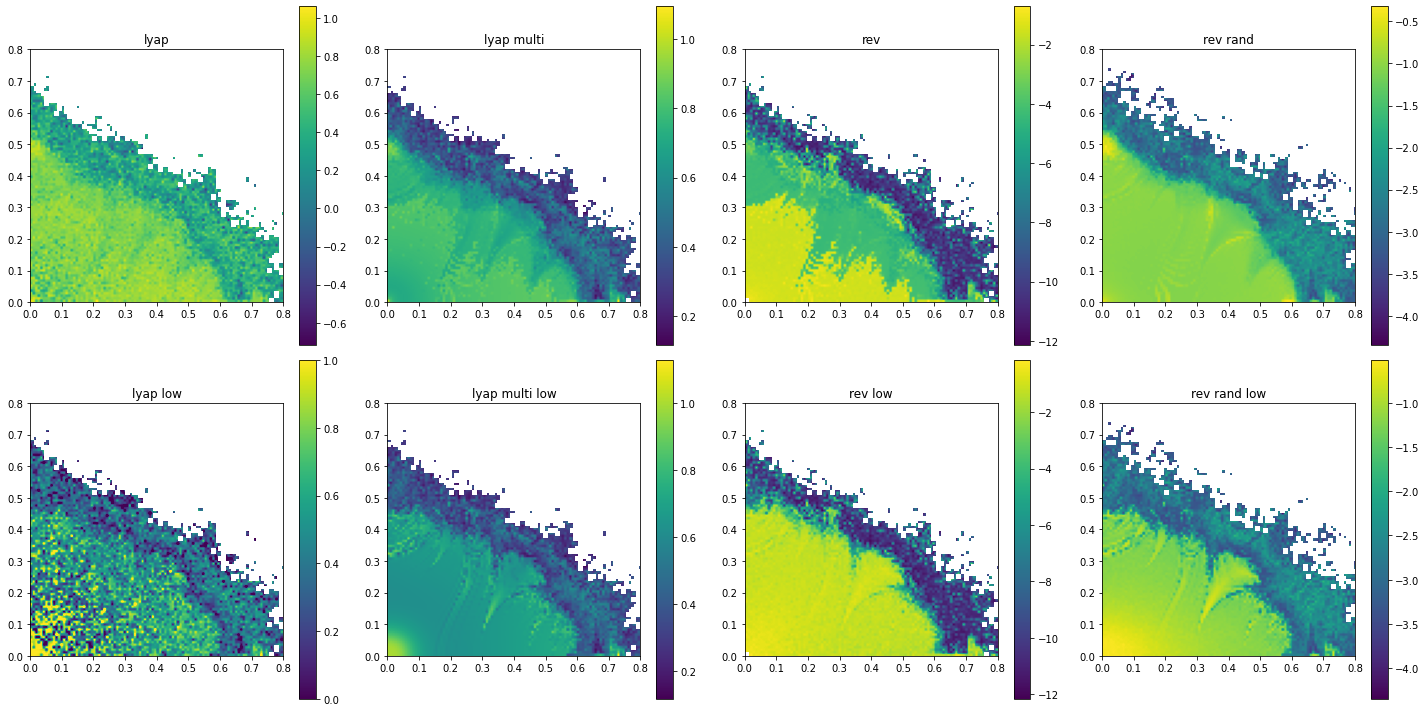

In [48]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

map = axs[0][0].imshow(par_lyap_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][0])
axs[0][0].set_title("lyap")

map = axs[1][0].imshow(par_lyap_low_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis", vmin=0, vmax=1)
fig.colorbar(map, ax=axs[1][0])
axs[1][0].set_title("lyap low")


map = axs[0][1].imshow(par_lyapm_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][1])
axs[0][1].set_title("lyap multi")

map = axs[1][1].imshow(par_lyapm_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][1])
axs[1][1].set_title("lyap multi low")


map = axs[0][2].imshow(par_rev_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][2])
axs[0][2].set_title("rev")

map = axs[1][2].imshow(par_rev_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][2])
axs[1][2].set_title("rev low")


map = axs[0][3].imshow(par_revr_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][3])
axs[0][3].set_title("rev rand")

map = axs[1][3].imshow(par_revr_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][3])
axs[1][3].set_title("rev rand low")


plt.tight_layout()


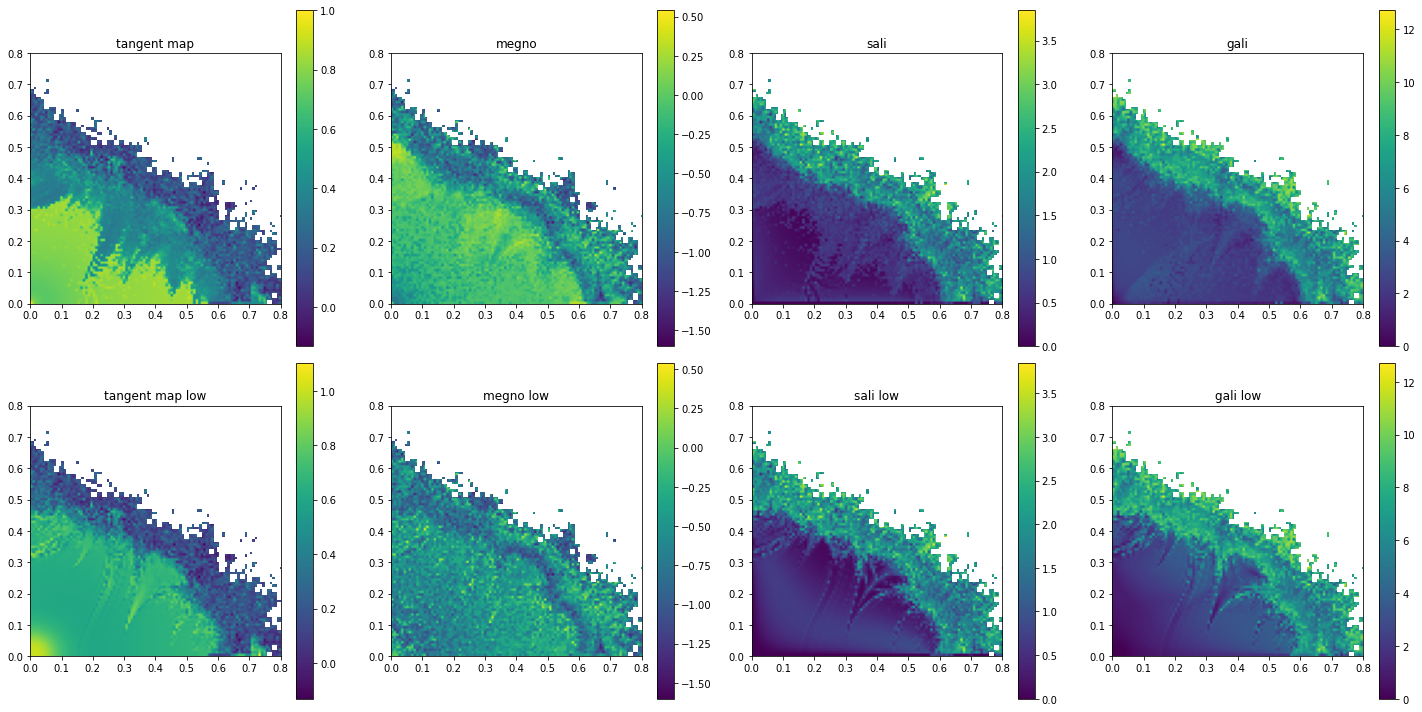

In [49]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

map = axs[0][0].imshow(par_tm_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][0])
axs[0][0].set_title("tangent map")

map = axs[1][0].imshow(par_tm_low_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][0])
axs[1][0].set_title("tangent map low")


map = axs[0][1].imshow(par_megno_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][1])
axs[0][1].set_title("megno")

map = axs[1][1].imshow(par_megno_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][1])
axs[1][1].set_title("megno low")


map = axs[0][2].imshow(par_sali_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][2])
axs[0][2].set_title("sali")

map = axs[1][2].imshow(par_sali_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][2])
axs[1][2].set_title("sali low")


map = axs[0][3].imshow(par_gali_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][3])
axs[0][3].set_title("gali")

map = axs[1][3].imshow(par_gali_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][3])
axs[1][3].set_title("gali low")


plt.tight_layout()


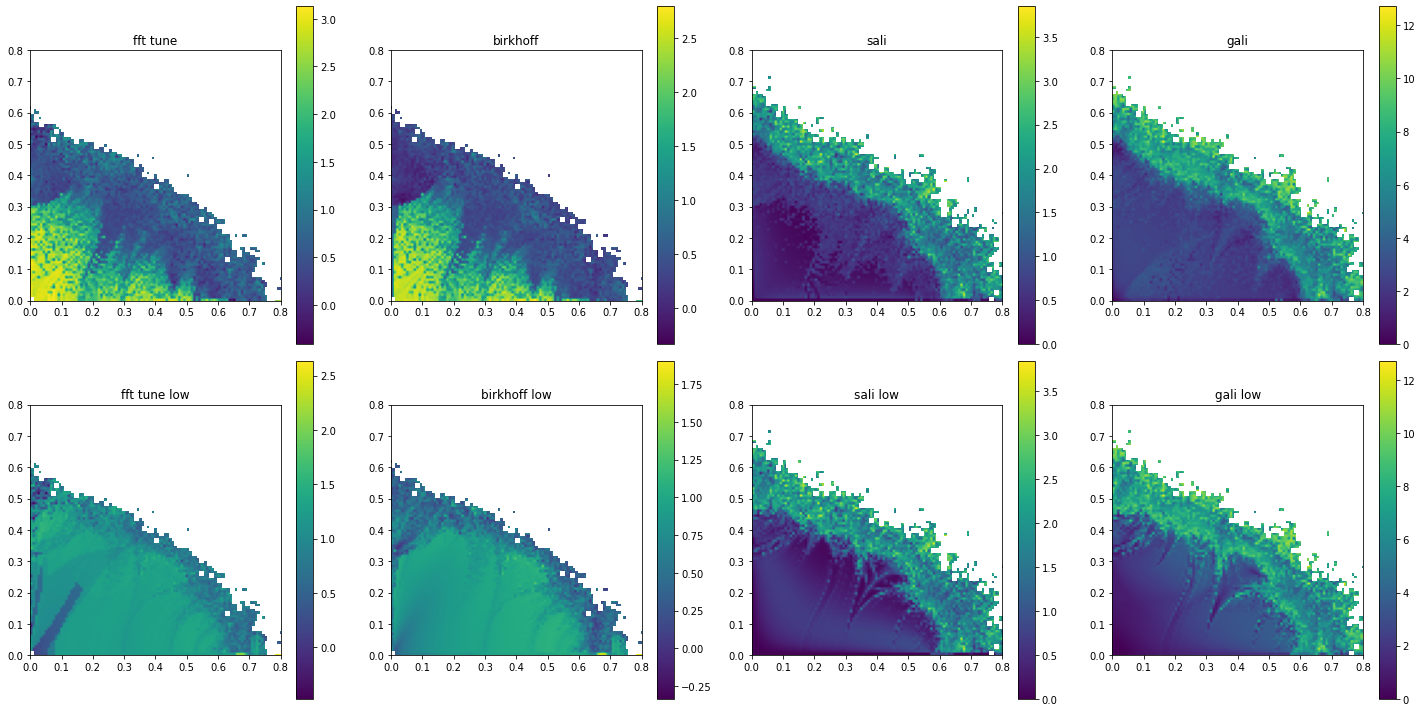

In [50]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

map = axs[0][0].imshow(par_fft_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][0])
axs[0][0].set_title("fft tune")

map = axs[1][0].imshow(par_fft_low_k.reshape(samples, samples),
                    origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][0])
axs[1][0].set_title("fft tune low")


map = axs[0][1].imshow(par_birkhoff_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][1])
axs[0][1].set_title("birkhoff")

map = axs[1][1].imshow(par_birkhoff_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][1])
axs[1][1].set_title("birkhoff low")


map = axs[0][2].imshow(par_sali_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][2])
axs[0][2].set_title("sali")

map = axs[1][2].imshow(par_sali_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][2])
axs[1][2].set_title("sali low")


map = axs[0][3].imshow(par_gali_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[0][3])
axs[0][3].set_title("gali")

map = axs[1][3].imshow(par_gali_low_k.reshape(samples, samples),
                       origin="lower", extent=extents, cmap="viridis")
fig.colorbar(map, ax=axs[1][3])
axs[1][3].set_title("gali low")


plt.tight_layout()


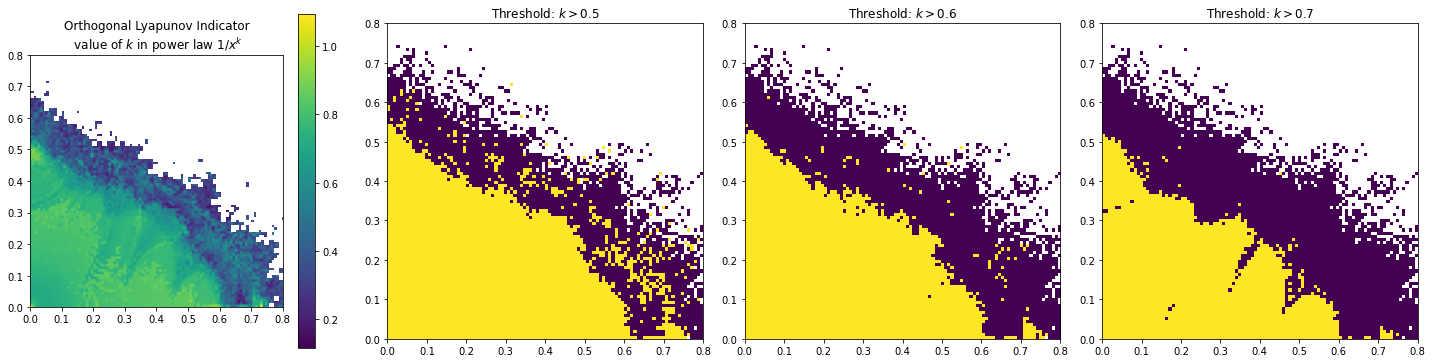

In [51]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
map = axs[0].imshow((par_lyapm_k).reshape(samples, samples),
    extent=extents, origin="lower", cmap="viridis")
# add colorbar
fig.colorbar(map, ax=axs[0])
axs[0].set_title("Orthogonal Lyapunov Indicator\n value of $k$ in power law $1/x^k$")


for i, thresh in enumerate([0.5, 0.6, 0.7]):
    mask = np.asarray(par_lyapm_k>thresh, dtype=float)
    mask[np.isnan(par_lyapm_k)] = np.nan

    axs[i+1].imshow(mask.reshape(samples, samples),
        extent=extents, origin="lower", cmap="viridis")
    axs[i+1].set_title(f"Threshold: $k>${thresh}")

plt.tight_layout()

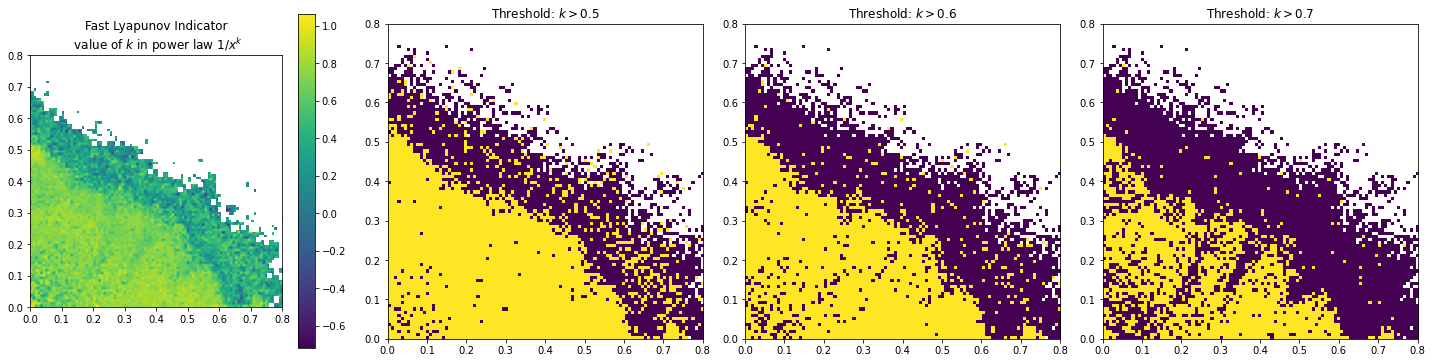

In [52]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
map = axs[0].imshow((par_lyap_k).reshape(samples, samples),
    extent=extents, origin="lower", cmap="viridis")
# add colorbar
fig.colorbar(map, ax=axs[0])
axs[0].set_title("Fast Lyapunov Indicator\n value of $k$ in power law $1/x^k$")


for i, thresh in enumerate([0.5, 0.6, 0.7]):
    mask = np.asarray(par_lyap_k>thresh, dtype=float)
    mask[np.isnan(par_lyapm_k)] = np.nan

    axs[i+1].imshow(mask.reshape(samples, samples),
        extent=extents, origin="lower", cmap="viridis")
    axs[i+1].set_title(f"Threshold: $k>${thresh}")

plt.tight_layout()

## Some random inspection plots...

idx: 1086


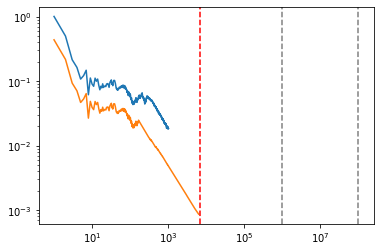

In [61]:
idx = np.where(
    np.logical_and(radius < 0.7, radius > 0.5)
)[0]
idx = idx[np.random.randint(0, len(idx))]
idx=1086
print(f"idx: {idx}")

x, y = clean_data(
    lyapunov.iloc[idx].index.to_numpy(),
    lyapunov.iloc[idx].to_numpy()
)

plt.plot(x, y)


x, y = clean_data(
    better_lyapunov.iloc[idx].index.to_numpy(),
    better_lyapunov.iloc[idx].to_numpy()
)

plt.plot(x, y)

plt.axvline(stability[idx], color="red", linestyle="--")
plt.axvline(1e6, color="grey", linestyle="--")
plt.axvline(1e8, color="grey", linestyle="--")

plt.xscale("log")
plt.yscale("log")

idx: 1086


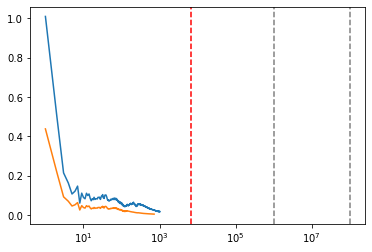

In [19]:
idx = np.where(
    np.logical_and(radius < 0.7, radius > 0.5)
)[0]
idx = idx[np.random.randint(0, len(idx))]
idx=1086
print(f"idx: {idx}")

x, y = clean_data(
    lyapunov.iloc[idx].index.to_numpy(),
    lyapunov.iloc[idx].to_numpy()
)

plt.plot(x, y)


x, y = clean_data(
    better_lyapunov.iloc[idx].index.to_numpy(),
    better_lyapunov.iloc[idx].to_numpy()
)

plt.plot(x, y)

plt.axvline(stability[idx], color="red", linestyle="--")
plt.axvline(1e6, color="grey", linestyle="--")
plt.axvline(1e8, color="grey", linestyle="--")

plt.xscale("log")
#plt.yscale("log")

idx: 2136


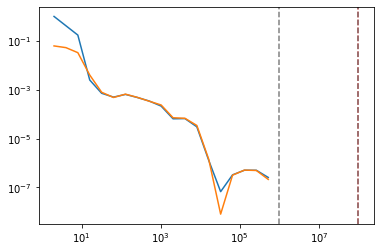

In [ ]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

x, y = clean_data(
    fft_tunes.iloc[idx].index.to_numpy(),
    fft_tunes.iloc[idx].to_numpy()
)

plt.plot(x, y)


x, y = clean_data(
    birkhoff_tunes.iloc[idx].index.to_numpy(),
    birkhoff_tunes.iloc[idx].to_numpy()
)

plt.plot(x, y)

plt.axvline(stability[idx], color="red", linestyle="--")
plt.axvline(1e6, color="grey", linestyle="--")
plt.axvline(1e8, color="grey", linestyle="--")

plt.xscale("log")
plt.yscale("log")

idx: 2867
a: -0.8576962072502691, k: 0.3570718495684639


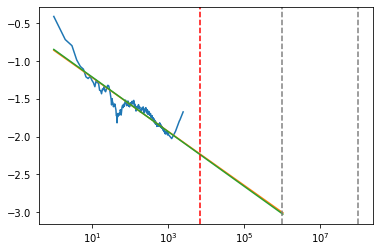

In [112]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

x, y = clean_data(
    tangent_map.iloc[idx].index.to_numpy(),
    tangent_map.iloc[idx].to_numpy()
)

plt.plot(x, np.log10(y))

plt.plot(
    tangent_map.iloc[idx].index.to_numpy(),
    log_fit(
        tangent_map.iloc[idx].index.to_numpy(),
        par_tm_a[idx], par_tm_k[idx]
    )
)


plt.plot(
    tangent_map.iloc[idx].index.to_numpy(),
    log_fit(
        tangent_map.iloc[idx].index.to_numpy(),
        par_tm_low_a[idx], par_tm_low_k[idx]
    )
)

plt.axvline(stability[idx], color="red", linestyle="--")
plt.axvline(1e6, color="grey", linestyle="--")
plt.axvline(1e8, color="grey", linestyle="--")

print(f"a: {par_tm_a[idx]}, k: {par_tm_k[idx]}")

plt.xscale("log")

idx: 6611
a: -0.7932105873733077, k: 0.4154526856857073


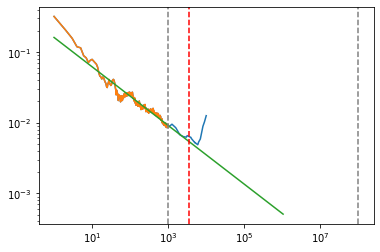

In [115]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    tangent_map.iloc[idx].index.to_numpy(),
    tangent_map.iloc[idx].to_numpy()
)

plt.plot(
    tangent_map_low.iloc[idx].index.to_numpy(),
    tangent_map_low.iloc[idx].to_numpy()
)

plt.plot(
    tangent_map.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        tangent_map.iloc[idx].index.to_numpy(),
        par_tm_low_a[idx], par_tm_low_k[idx]
    ))
)

plt.axvline(stability[idx], color="red", linestyle="--")
plt.axvline(1e3, color="grey", linestyle="--")
plt.axvline(1e8, color="grey", linestyle="--")

print(f"a: {par_tm_low_a[idx]}, k: {par_tm_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

In [106]:
print(np.nanmax(tangent_map.iloc[idx].to_numpy()))
print(np.nanmin(tangent_map.iloc[idx].to_numpy()))


inf
4.163399299210879


/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


(1, 1e+200)

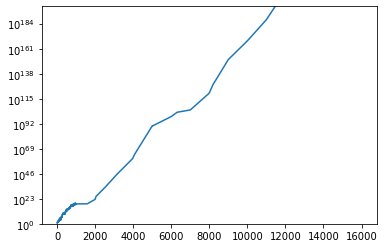

In [75]:
plt.plot(
    tangent_map.iloc[idx].index.to_numpy(),
    tangent_map.iloc[idx].to_numpy()
)
plt.yscale("log")
plt.ylim(1,1e200)


idx: 648
a: 2.293570760861568, k: 2.5910160936434252


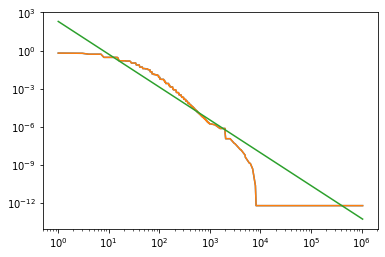

In [39]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    gali.iloc[idx].index.to_numpy(),
    gali.iloc[idx].to_numpy()
)

plt.plot(
    gali.iloc[idx].index.to_numpy(),
    gali.iloc[idx].to_numpy()
)

plt.plot(
    gali.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        gali.iloc[idx].index.to_numpy(),
        par_gali_a[idx], par_gali_k[idx]
    ))
)

print(f"a: {par_gali_a[idx]}, k: {par_gali_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 473
a: -6.015742491427513, k: -1.0477427443014176


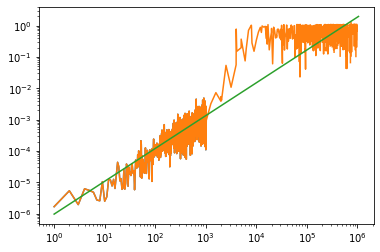

In [40]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    reverse_rand_low.iloc[idx].index.to_numpy(),
    reverse_rand_low.iloc[idx].to_numpy()
)

plt.plot(
    reverse_rand.iloc[idx].index.to_numpy(),
    reverse_rand.iloc[idx].to_numpy()
)

plt.plot(
    reverse_rand.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        reverse_rand.iloc[idx].index.to_numpy(),
        par_revr_a[idx], par_revr_k[idx]
    ))
)

print(f"a: {par_revr_a[idx]}, k: {par_revr_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 243
a: -18.353432885011596, k: -1.577887795070826


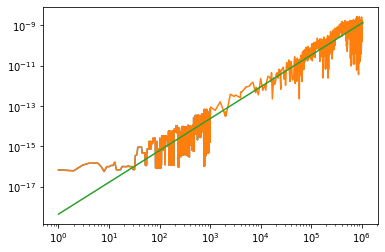

In [41]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]

idx = 243
print(f"idx: {idx}")

plt.plot(
    reverse_low.iloc[idx].index.to_numpy(),
    reverse_low.iloc[idx].to_numpy()
)

plt.plot(
    reverse.iloc[idx].index.to_numpy(),
    reverse.iloc[idx].to_numpy()
)

plt.plot(
    reverse.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        reverse.iloc[idx].index.to_numpy(),
        par_rev_a[idx], par_rev_k[idx]
    ))
)


print(f"a: {par_rev_a[idx]}, k: {par_rev_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 4844
ALL -> a: -0.24732571863306618, k: 0.47126266395375904
LOW -> a: -0.24964701327885913, k: 0.4702276340012529


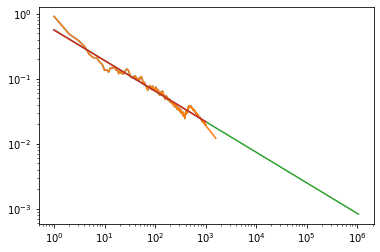

In [145]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

plt.plot(
    lyapunov_multi_low.iloc[idx].index.to_numpy(),
    lyapunov_multi_low.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov_multi.iloc[idx].index.to_numpy(),
    lyapunov_multi.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov_multi.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_multi.iloc[idx].index.to_numpy(),
        par_lyapm_a[idx], par_lyapm_k[idx]
    ))
)

plt.plot(
    lyapunov_multi_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_multi_low.iloc[idx].index.to_numpy(),
        par_lyapm_low_a[idx], par_lyapm_low_k[idx]
    ))
)

print(f"ALL -> a: {par_lyapm_a[idx]}, k: {par_lyapm_k[idx]}")
print(f"LOW -> a: {par_lyapm_low_a[idx]}, k: {par_lyapm_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 5334
ALL -> a: -1.9102297206542307, k: -0.19293626095768368
LOW -> a: -1.9102297206542307, k: -0.19293626095768368


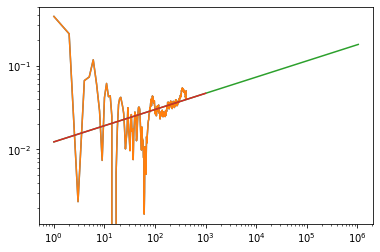

In [43]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]
print(f"idx: {idx}")

idx = 6409

plt.plot(
    lyapunov_low.iloc[idx].index.to_numpy(),
    lyapunov_low.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov.iloc[idx].index.to_numpy(),
    lyapunov.iloc[idx].to_numpy()
)

plt.plot(
    lyapunov.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov.iloc[idx].index.to_numpy(),
        par_lyap_a[idx], par_lyap_k[idx]
    ))
)

plt.plot(
    lyapunov_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_low.iloc[idx].index.to_numpy(),
        par_lyap_low_a[idx], par_lyap_low_k[idx]
    ))
)

print(f"ALL -> a: {par_lyap_a[idx]}, k: {par_lyap_k[idx]}")
print(f"LOW -> a: {par_lyap_low_a[idx]}, k: {par_lyap_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

idx: 5818
ALL -> a: -0.5814668047496003, k: -0.3087273340679146
LOW -> a: -0.5681539149619885, k: -0.30304733736762673


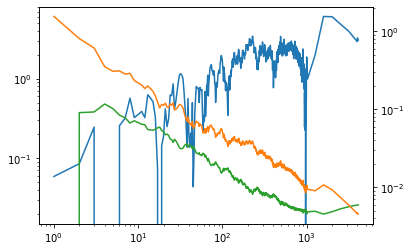

In [60]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]

#idx = 3248
print(f"idx: {idx}")

# plt.plot(
#     megno_low.iloc[idx].index.to_numpy(),
#     megno_low.iloc[idx].to_numpy()
# )

plt.plot(
    megno.iloc[idx].index.to_numpy(),
    megno.iloc[idx].to_numpy()
)

# plt.plot(
#     megno.iloc[idx].index.to_numpy(),
#     np.power(10, log_fit(
#         megno.iloc[idx].index.to_numpy(),
#         par_megno_a[idx], par_megno_k[idx]
#     ))
# )

# plt.plot(
#     megno_low.iloc[idx].index.to_numpy(),
#     np.power(10, log_fit(
#         megno_low.iloc[idx].index.to_numpy(),
#         par_megno_low_a[idx], par_megno_low_k[idx]
#     ))
# )



tx = lyapunov.iloc[idx].index.to_numpy()
ty = lyapunov.iloc[idx].to_numpy()

ty_n = -np.array([
    ty[i] - np.average(ty[:i+1]) for i in range(len(ty))
])
plt.plot(
    tx, ty_n, c="C2"
)
plt.yscale("log")

plt.twinx()

plt.plot(
    lyapunov.iloc[idx].index.to_numpy(),
    lyapunov.iloc[idx].to_numpy(),
    color="C1"
)

print(f"ALL -> a: {par_megno_a[idx]}, k: {par_megno_k[idx]}")
print(f"LOW -> a: {par_megno_low_a[idx]}, k: {par_megno_low_k[idx]}")

plt.xscale("log")
plt.yscale("log")

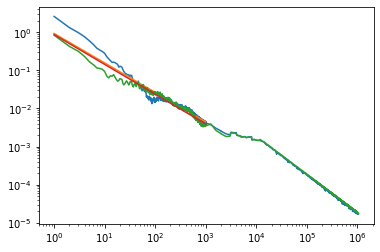

In [80]:
idx = np.where(
    np.logical_and(radius < 0.6, radius > 0.3)
)[0]
idx = idx[np.random.randint(0, len(idx))]


plt.plot(
    lyapunov.iloc[idx].index.to_numpy(),
    lyapunov.iloc[idx].to_numpy(),
)

plt.plot(
    lyapunov_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_low.iloc[idx].index.to_numpy(),
        par_lyap_low_a[idx], par_lyap_low_k[idx]
    ))
)

plt.plot(
    lyapunov_multi.iloc[idx].index.to_numpy(),
    lyapunov_multi.iloc[idx].to_numpy(),
)

plt.plot(
    lyapunov_low.iloc[idx].index.to_numpy(),
    np.power(10, log_fit(
        lyapunov_low.iloc[idx].index.to_numpy(),
        par_lyapm_low_a[idx], par_lyapm_low_k[idx]
    ))
)
plt.xscale("log")
plt.yscale("log")

## Some random correlation plots...

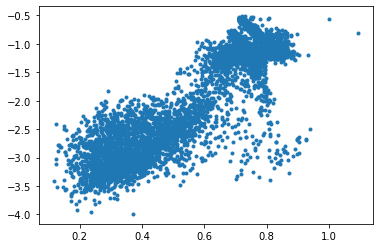

In [179]:
plt.plot(
    par_lyapm_k,
    par_revr_low_k,
    "."
)

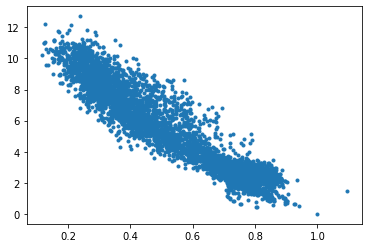

In [64]:
plt.plot(
    par_lyapm_k,
    par_gali_k,
    "."
)

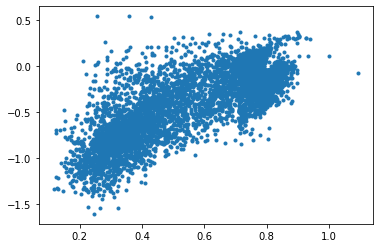

In [63]:
plt.plot(
    par_lyapm_k,
    par_megno_k,
    "."
)

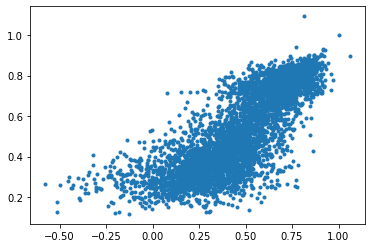

In [181]:
plt.plot(
    par_lyap_k,
    par_lyapm_k,
    "."
)

## Confusion plots

In [54]:
def classify_with_data(stab_data, dyn_data, dyn_thresh, stable_if_higher=False):
    bool_mask = np.logical_not(np.logical_or(
        np.isnan(stab_data), np.isnan(dyn_data)))
    stab_data = stab_data[bool_mask]
    dyn_data = dyn_data[bool_mask]
    data = stab_data# >= stab_thresh
    guess = (dyn_data >= dyn_thresh) if stable_if_higher else (
        dyn_data <= dyn_thresh)

    total = data.size
    tp = np.count_nonzero(data & guess)
    fp = np.count_nonzero(data & ~guess)
    fn = np.count_nonzero(~data & guess)
    tn = np.count_nonzero(~data & ~guess)

    accuracy = (tp + tn) / total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return dict(
        tp=tp, fp=fp, fn=fn, tn=tn, total=total, accuracy=accuracy,
        precision=precision, recall=recall
    )


In [74]:
to_compare = par_lyapm_low_k
stable_if_higher = True
title = "ortho lyapunov at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

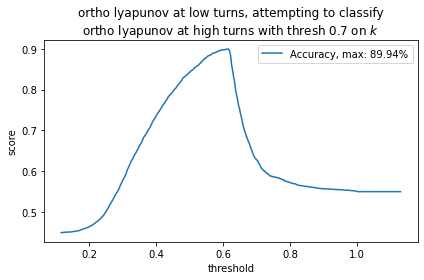

In [75]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [101]:
to_compare = par_lyap_low_k
stable_if_higher = True
title = "simple lyapunov at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

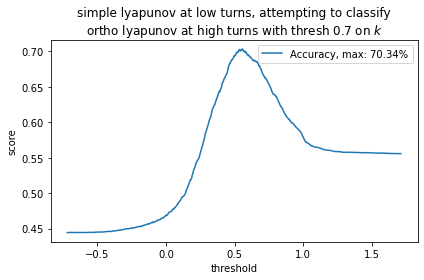

In [102]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [103]:
to_compare = par_tm_low_k
stable_if_higher = True
title = "Invariant Lyapunov at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

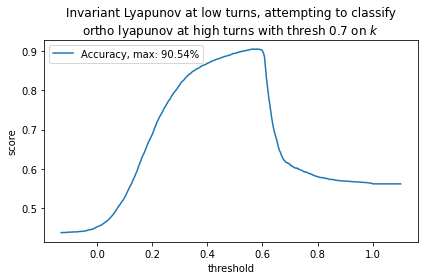

In [104]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [76]:
to_compare = par_gali_low_k
stable_if_higher = False
title = "gali at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

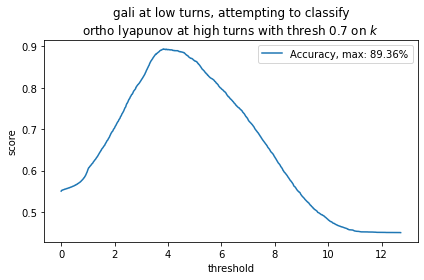

In [77]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [78]:
to_compare = par_sali_low_k
stable_if_higher = False
title = "sali at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

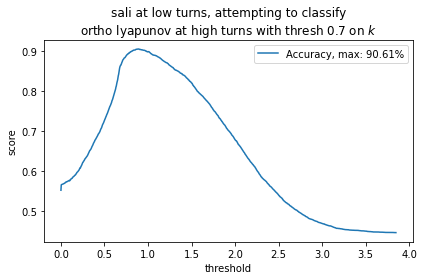

In [79]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [86]:
to_compare = par_rev_low_k
stable_if_higher = True
title = "numerical reversibility at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

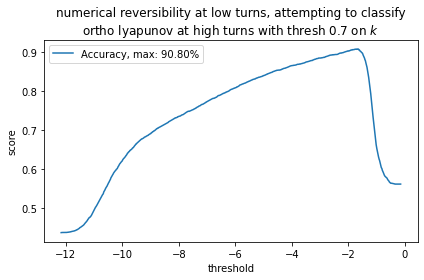

In [87]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [88]:
to_compare = par_revr_low_k
stable_if_higher = True
title = "reversibility with extra kick at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

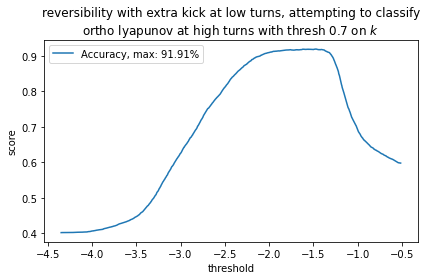

In [89]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [90]:
to_compare = par_birkhoff_low_k
stable_if_higher = True
title = "birkhoff tunes at low turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))

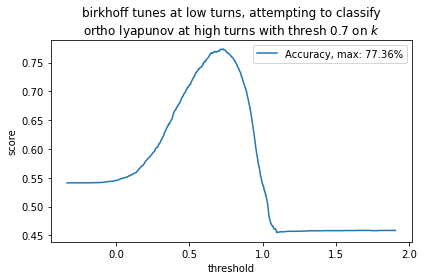

In [91]:
accuracy = np.array([c["accuracy"] for c in confusion])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy, max: {np.max(accuracy)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

## Double confusion plots!

In [105]:
to_compare = par_lyap_low_k
to_compare_2 = par_lyap_k
stable_if_higher = True
title = "simple lyapunov at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

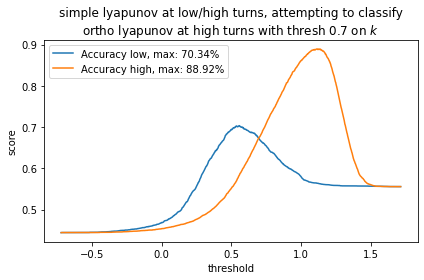

In [108]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [114]:
to_compare = par_rev_low_k
to_compare_2 = par_rev_k
stable_if_higher = True
title = "numerical reverse error at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

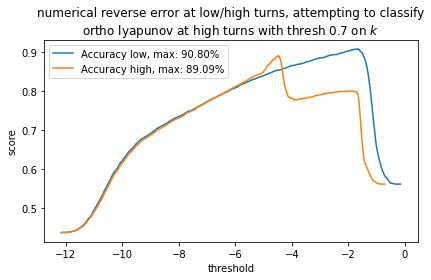

In [115]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples_2, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [117]:
to_compare = par_revr_low_k
to_compare_2 = par_revr_k
stable_if_higher = True
title = "Reverse error with kick at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

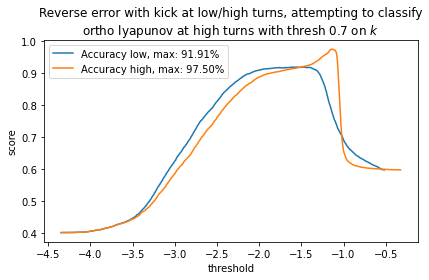

In [118]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples_2, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [122]:
to_compare = par_sali_low_k
to_compare_2 = par_sali_k
stable_if_higher = False
title = "sali at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

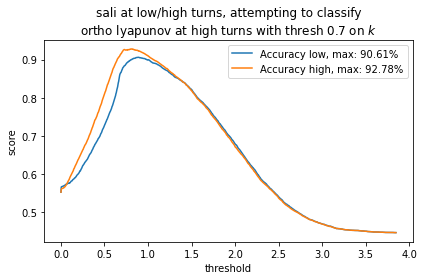

In [123]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples_2, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [124]:
to_compare = par_gali_low_k
to_compare_2 = par_gali_k
stable_if_higher = False
title = "gali at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

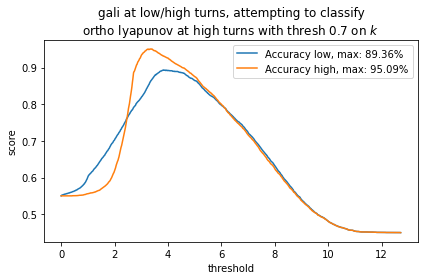

In [125]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples_2, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [130]:
to_compare = par_tm_low_k
to_compare_2 = par_tm_k
stable_if_higher = True
title = "Invarian lyapunov at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

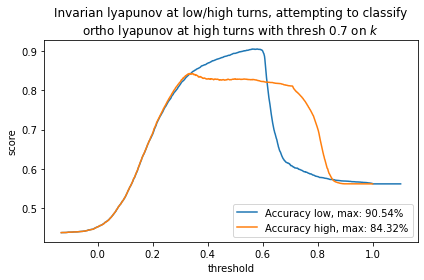

In [131]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples_2, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

In [134]:
to_compare = par_birkhoff_low_k
to_compare_2 = par_birkhoff_k
stable_if_higher = True
title = "birkhoff at low/high turns, attempting to classify\northo lyapunov at high turns with thresh 0.7 on $k$"


samples = np.linspace(
    np.nanmin(to_compare),
    np.nanmax(to_compare),
    1000
)

confusion = []
for s in samples:
    confusion.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare, s,
            stable_if_higher=stable_if_higher
))
    
samples_2 = np.linspace(
    np.nanmin(to_compare_2),
    np.nanmax(to_compare_2),
    1000
)

confusion_2 = []
for s in samples_2:
    confusion_2.append(
        classify_with_data(
            (par_lyapm_k > 0.7),
            to_compare_2, s,
            stable_if_higher=stable_if_higher
))

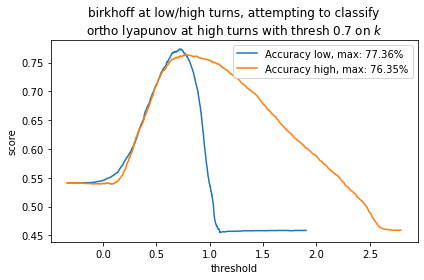

In [135]:
accuracy = np.array([c["accuracy"] for c in confusion])
accuracy_2 = np.array([c["accuracy"] for c in confusion_2])
precision = np.array([c["precision"] for c in confusion])
recall = np.array([c["recall"] for c in confusion])
tp = np.array([c["tp"] for c in confusion])
tn = np.array([c["tn"] for c in confusion])
fp = np.array([c["fp"] for c in confusion])
fn = np.array([c["fn"] for c in confusion])
total = tp + tn + fp + fn

plt.plot(samples, accuracy, label=f"Accuracy low, max: {np.max(accuracy)*100:.2f}%")
plt.plot(samples_2, accuracy_2, label=f"Accuracy high, max: {np.max(accuracy_2)*100:.2f}%")
#plt.plot(samples, tp/total, label="tp")
#plt.plot(samples, tn/total, label="tn")
#plt.plot(samples, fp/total, label="fp")
#plt.plot(samples, fn/total, label="fn")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("score")
plt.title(title)
plt.tight_layout()

## Other fits...

In [29]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_3"
    ) for i, (x, y) in enumerate(zip(
        better_lyapunov.iterrows(),
        stability
    ))
)

par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/

In [30]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_3"
    ) for i, (x, y) in enumerate(zip(
        better_lyapunov_low.iterrows(),
        stability
    ))
)

par_lyapm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/HPC/camontan/miniconda3/lib/python3.9/site-packages/lmfit/

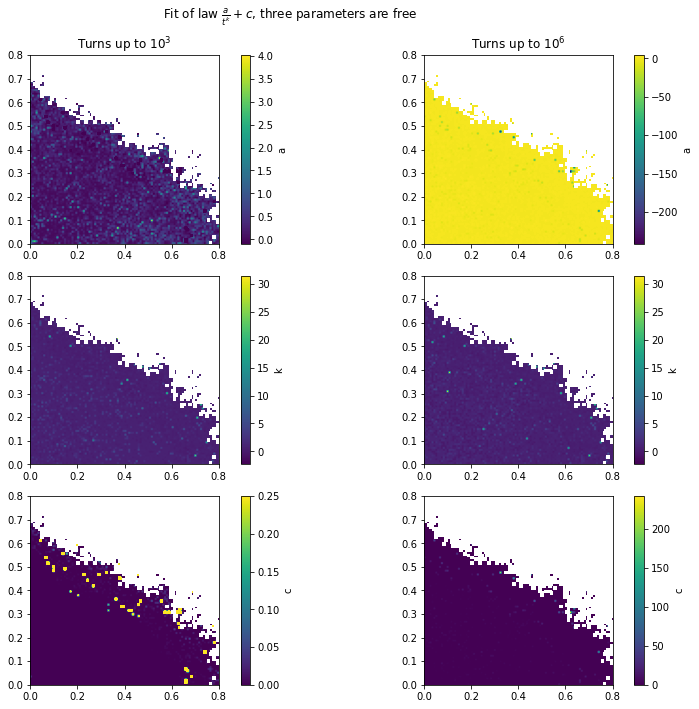

In [31]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, three parameters are free")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")

map = axs[0][0].imshow(par_lyapm_a.reshape(100, 100), origin="lower", extent=extents, vmin=-0.1)
figs.colorbar(map, ax=axs[0][0], label="a")
map = axs[1][0].imshow(par_lyapm_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label="k")
map = axs[2][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents, vmax=0.25)
figs.colorbar(map, ax=axs[2][0], label="c")

map = axs[0][1].imshow(par_lyapm_low_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="a")
map = axs[1][1].imshow(par_lyapm_low_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label="k")
map = axs[2][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label="c")

plt.tight_layout()

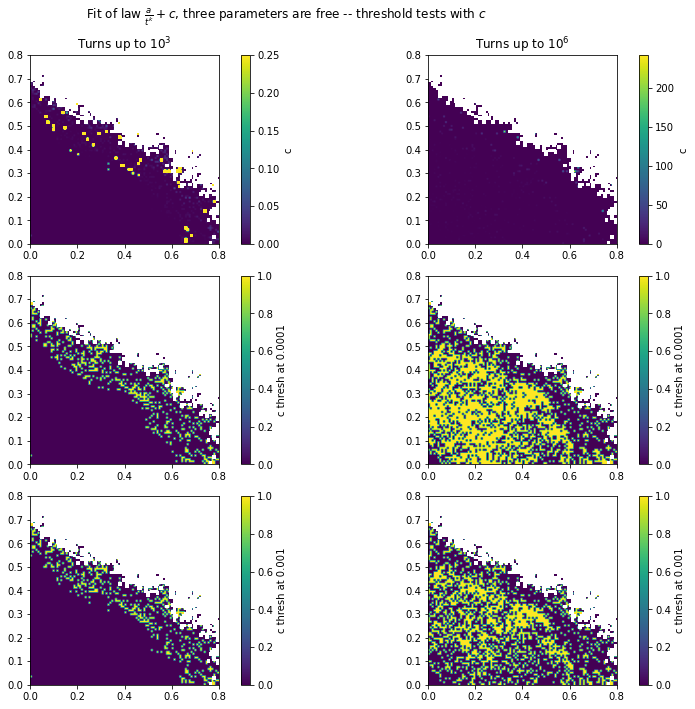

In [32]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

th1 = 0.0001
th2 = 0.001

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, three parameters are free -- threshold tests with $c$")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")


map = axs[0][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents, vmax=0.25)
figs.colorbar(map, ax=axs[0][0], label="c")
mask = np.asarray(par_lyapm_c > th1, dtype=float)
mask[np.isnan(par_lyapm_c)] = np.nan
map = axs[1][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label=f"c thresh at {th1}")
mask = np.asarray(par_lyapm_c > th2, dtype=float)
mask[np.isnan(par_lyapm_c)] = np.nan
map = axs[2][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label=f"c thresh at {th2}")

map = axs[0][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="c")
mask = np.asarray(par_lyapm_low_c > th1, dtype=float)
mask[np.isnan(par_lyapm_low_c)] = np.nan
map = axs[1][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label=f"c thresh at {th1}")
mask = np.asarray(par_lyapm_low_c > th2, dtype=float)
mask[np.isnan(par_lyapm_low_c)] = np.nan
map = axs[2][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label=f"c thresh at {th2}")

plt.tight_layout()

In [26]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_fix_a"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi.iterrows(),
        stability
    ))
)

par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [27]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_fix_a"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi_low.iterrows(),
        stability
    ))
)

par_lyapm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

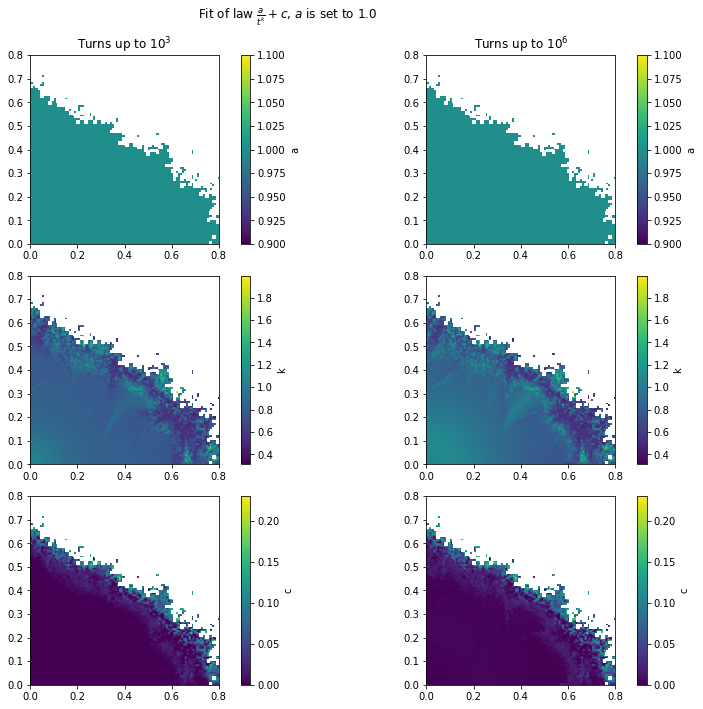

In [28]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $a$ is set to 1.0")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")

map = axs[0][0].imshow(par_lyapm_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="a")
map = axs[1][0].imshow(par_lyapm_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label="k")
map = axs[2][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label="c")

map = axs[0][1].imshow(par_lyapm_low_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="a")
map = axs[1][1].imshow(par_lyapm_low_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label="k")
map = axs[2][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label="c")

plt.tight_layout()

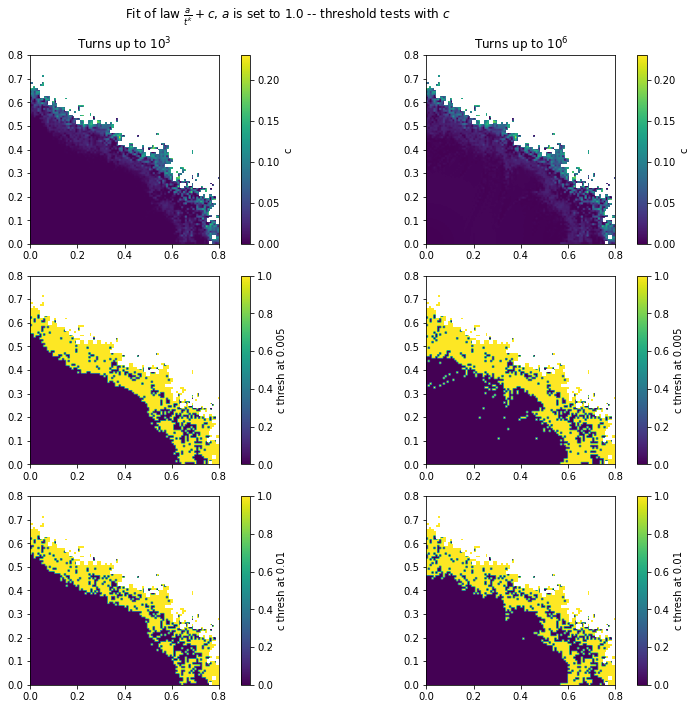

In [29]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

th1 = 0.005
th2 = 0.01

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $a$ is set to 1.0 -- threshold tests with $c$")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")


map = axs[0][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="c")
mask = np.asarray(par_lyapm_c > th1, dtype=float)
mask[np.isnan(par_lyapm_c)] = np.nan
map = axs[1][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label=f"c thresh at {th1}")
mask = np.asarray(par_lyapm_c > th2, dtype=float)
mask[np.isnan(par_lyapm_c)] = np.nan
map = axs[2][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label=f"c thresh at {th2}")

map = axs[0][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="c")
mask = np.asarray(par_lyapm_low_c > th1, dtype=float)
mask[np.isnan(par_lyapm_low_c)] = np.nan
map = axs[1][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label=f"c thresh at {th1}")
mask = np.asarray(par_lyapm_low_c > th2, dtype=float)
mask[np.isnan(par_lyapm_low_c)] = np.nan
map = axs[2][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label=f"c thresh at {th2}")

plt.tight_layout()

In [33]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_fix_k"
    ) for i, (x, y) in enumerate(zip(
        better_lyapunov.iterrows(),
        stability
    ))
)

par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [34]:
report_list[210]

In [35]:
par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_a_err = np.array([x.params["a"].stderr if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k_err = np.array([x.params["k"].stderr if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_c_err = np.array([x.params["c"].stderr if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

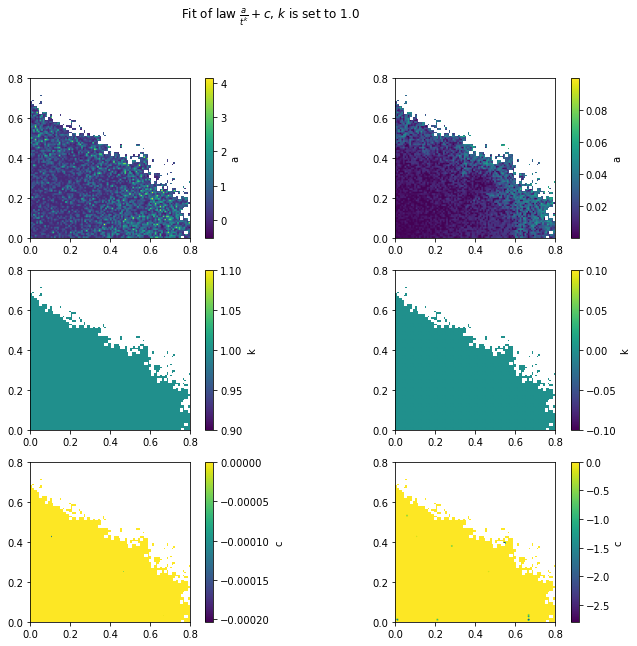

In [36]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $k$ is set to 1.0")

map = axs[0][0].imshow(par_lyapm_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="a")
map = axs[1][0].imshow(par_lyapm_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label="k")
map = axs[2][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents, vmax=0)
figs.colorbar(map, ax=axs[2][0], label="c")

map = axs[0][1].imshow(par_lyapm_a_err.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="a")
map = axs[1][1].imshow(par_lyapm_k_err.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label="k")
map = axs[2][1].imshow((par_lyapm_c_err/par_lyapm_c).reshape(100, 100), origin="lower", extent=extents, vmax=0)
figs.colorbar(map, ax=axs[2][1], label="c")

In [37]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_fix_k"
    ) for i, (x, y) in enumerate(zip(
        better_lyapunov_low.iterrows(),
        stability
    ))
)

par_lyapm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

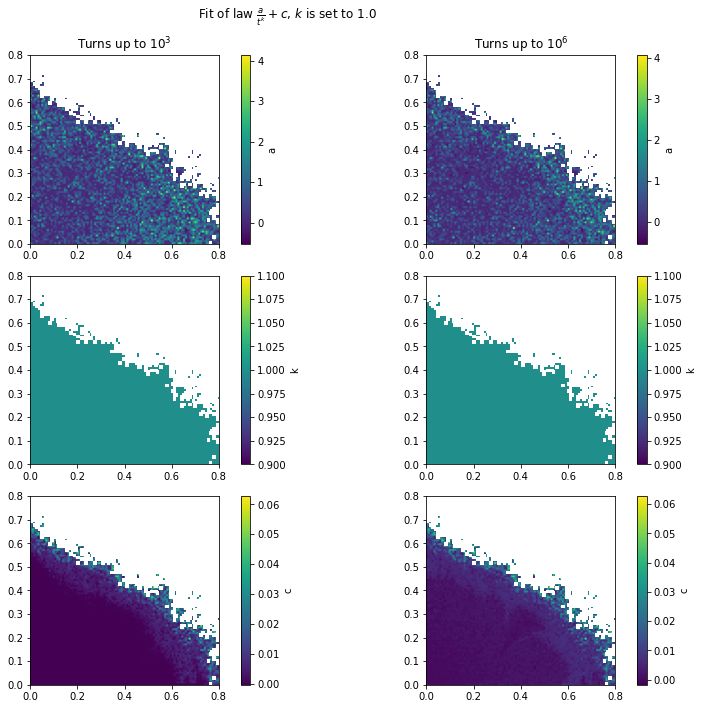

In [38]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $k$ is set to 1.0")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")

map = axs[0][0].imshow(par_lyapm_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="a")
map = axs[1][0].imshow(par_lyapm_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label="k")
map = axs[2][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label="c")

map = axs[0][1].imshow(par_lyapm_low_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="a")
map = axs[1][1].imshow(par_lyapm_low_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label="k")
map = axs[2][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label="c")

plt.tight_layout()

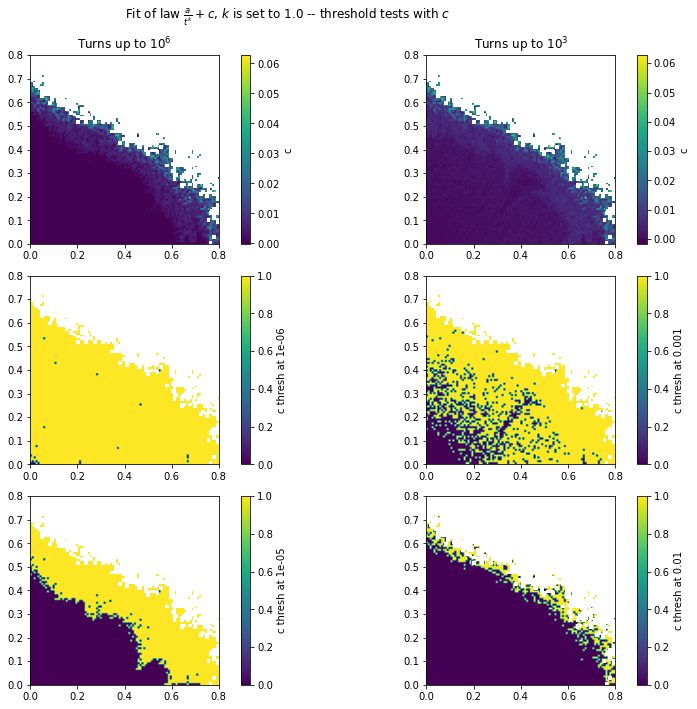

In [41]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

th1 = 1/10**6
th2 = 1/10**5

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $k$ is set to 1.0 -- threshold tests with $c$")
axs[0][0].set_title("Turns up to $10^6$")
axs[0][1].set_title("Turns up to $10^3$")


map = axs[0][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="c")
mask = np.asarray(par_lyapm_c > th1, dtype=float)
mask[np.isnan(par_lyapm_c)] = np.nan
map = axs[1][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label=f"c thresh at {th1}")
mask = np.asarray(par_lyapm_c > th2, dtype=float)
mask[np.isnan(par_lyapm_c)] = np.nan
map = axs[2][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label=f"c thresh at {th2}")


th1 = 1/10**3
th2 = 1/10**2

map = axs[0][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="c")
mask = np.asarray(par_lyapm_low_c > th1, dtype=float)
mask[np.isnan(par_lyapm_low_c)] = np.nan
map = axs[1][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label=f"c thresh at {th1}")
mask = np.asarray(par_lyapm_low_c > th2, dtype=float)
mask[np.isnan(par_lyapm_low_c)] = np.nan
map = axs[2][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label=f"c thresh at {th2}")

plt.tight_layout()

In [34]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_fix_c"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi.iterrows(),
        stability
    ))
)

par_lyapm_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

In [35]:
report_list = joblib.Parallel(n_jobs=njobs)(delayed(fit)(
    x[1].index.to_numpy(), x[1].to_numpy(), y, i, kind="fit_fix_c"
    ) for i, (x, y) in enumerate(zip(
        lyapunov_multi_low.iterrows(),
        stability
    ))
)

par_lyapm_low_a = np.array([x.params["a"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_k = np.array([x.params["k"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_c = np.array([x.params["c"].value if x != "error" and x !=
                      "discarded" else np.nan for x in report_list])
par_lyapm_low_chi = np.array([x.chisqr if x != "error" and x !=
                        "discarded" else np.nan for x in report_list])

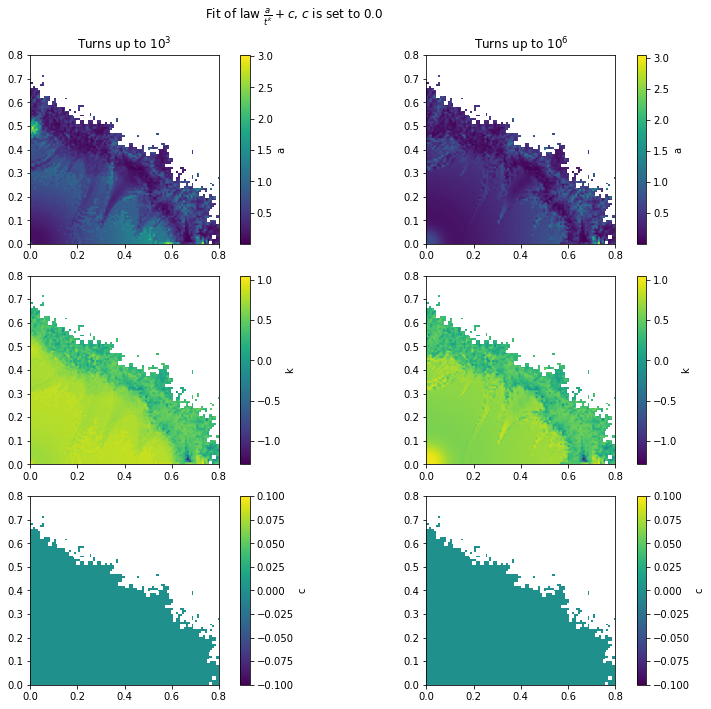

In [36]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $c$ is set to 0.0")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")

map = axs[0][0].imshow(par_lyapm_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="a")
map = axs[1][0].imshow(par_lyapm_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label="k")
map = axs[2][0].imshow(par_lyapm_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label="c")

map = axs[0][1].imshow(par_lyapm_low_a.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="a")
map = axs[1][1].imshow(par_lyapm_low_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label="k")
map = axs[2][1].imshow(par_lyapm_low_c.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label="c")

plt.tight_layout()

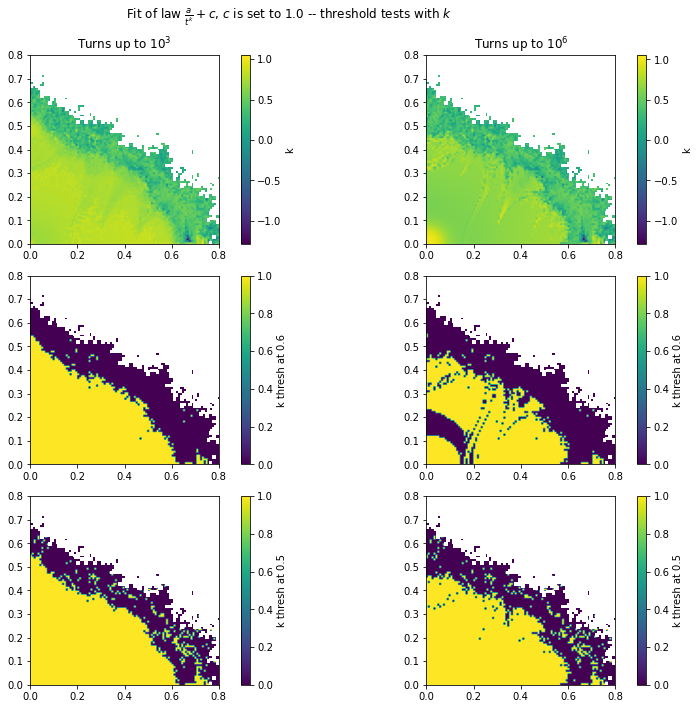

In [40]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))

th1 = 0.6
th2 = 0.5

figs.suptitle("Fit of law $\\frac{a}{t^k} + c$, $c$ is set to 1.0 -- threshold tests with $k$")
axs[0][0].set_title("Turns up to $10^3$")
axs[0][1].set_title("Turns up to $10^6$")


map = axs[0][0].imshow(par_lyapm_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][0], label="k")
mask = np.asarray(par_lyapm_k > th1, dtype=float)
mask[np.isnan(par_lyapm_k)] = np.nan
map = axs[1][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][0], label=f"k thresh at {th1}")
mask = np.asarray(par_lyapm_k > th2, dtype=float)
mask[np.isnan(par_lyapm_k)] = np.nan
map = axs[2][0].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][0], label=f"k thresh at {th2}")

map = axs[0][1].imshow(par_lyapm_low_k.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[0][1], label="k")
mask = np.asarray(par_lyapm_low_k > th1, dtype=float)
mask[np.isnan(par_lyapm_low_k)] = np.nan
map = axs[1][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[1][1], label=f"k thresh at {th1}")
mask = np.asarray(par_lyapm_low_k > th2, dtype=float)
mask[np.isnan(par_lyapm_low_k)] = np.nan
map = axs[2][1].imshow(mask.reshape(100, 100), origin="lower", extent=extents)
figs.colorbar(map, ax=axs[2][1], label=f"k thresh at {th2}")

plt.tight_layout()

### 1.1.0 - Colors!

In [18]:
# Make the base colors
colors_stability = dm.colorize(stability, log10=True)
colors_radius = dm.colorize(data.initial_radius(), vmax=0.7)
colors_rad_stab = dm.colorize(stability, log10=True)

In [19]:
# Mask considering radius
radius_color = 0.3

before_mask = data.initial_radius() <= radius_color
after_mask = data.initial_radius() > radius_color

In [20]:
colors_rad_stab[before_mask] = dm.colorize(
    stability[before_mask], log10=True, cmap="cool")
colors_rad_stab[after_mask] = dm.colorize(
    stability[after_mask], log10=True, cmap="Wistia")

### 1.1.1 - Invariant Lyapunov

Text(0, 0.5, 'Invariant Lyapunov Indicator at 1000')

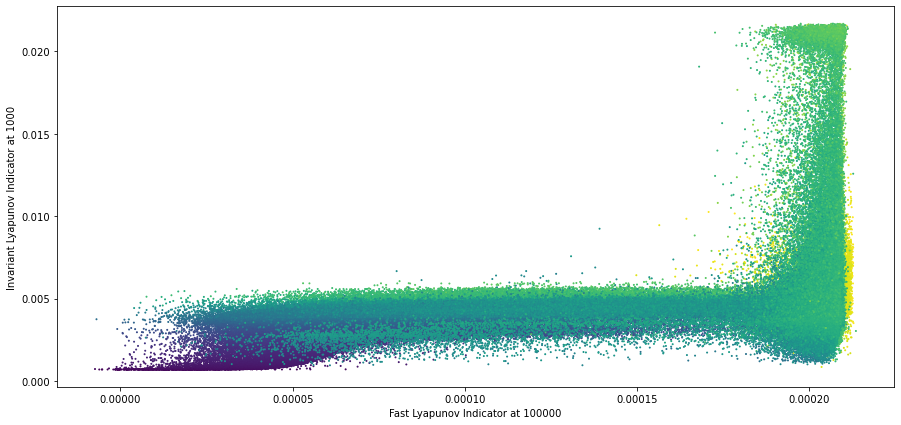

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t2].to_numpy(),
    lyapunov_multi[t1].to_numpy(),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Fast Lyapunov Indicator at {t2}")
ax.set_ylabel(f"Invariant Lyapunov Indicator at {t1}")

### 1.1.2 - Reversibility error

/tmp/ipykernel_8039/3124219978.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[t1].to_numpy()),


Text(0, 0.5, 'Reversibility Indicator at 1000')

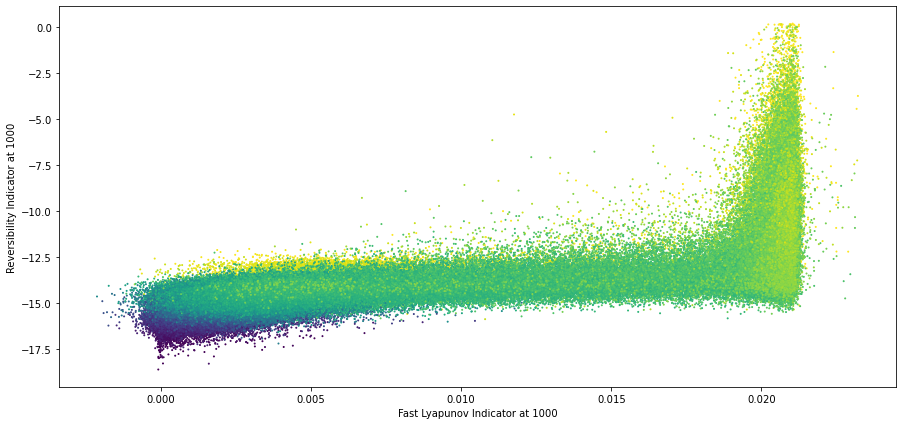

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    np.log10(reverse[t1].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Fast Lyapunov Indicator at {t1}")
ax.set_ylabel(f"Reversibility Indicator at {t1}")


### 1.1.3 - SALI and GALI

Text(0, 0.5, 'SALI at 1000')

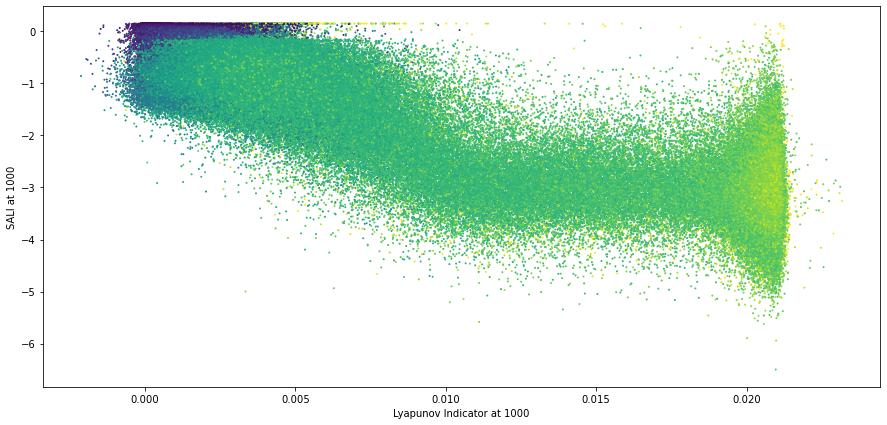

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    np.log10(sali[t1].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"SALI at {t1}")


Text(0, 0.5, 'GALI at 1000')

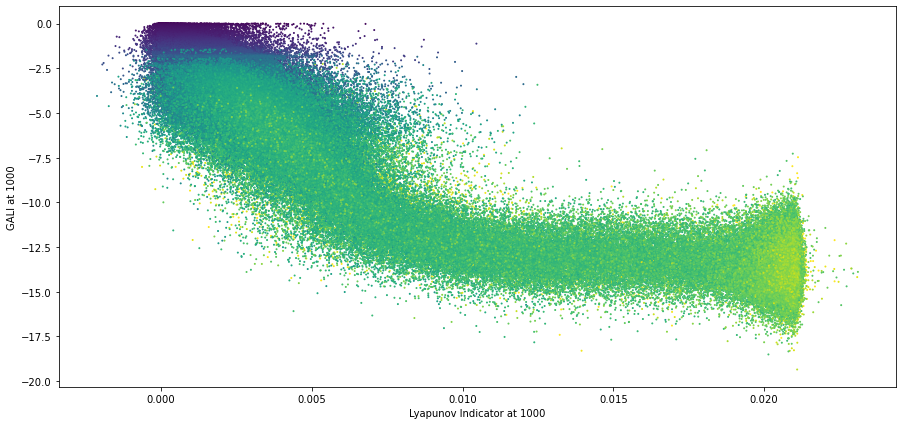

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    np.log10(gali[t1].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"GALI at {t1}")

### 1.1.4 - MEGNO

Text(0, 0.5, 'MEGNO at 100000')

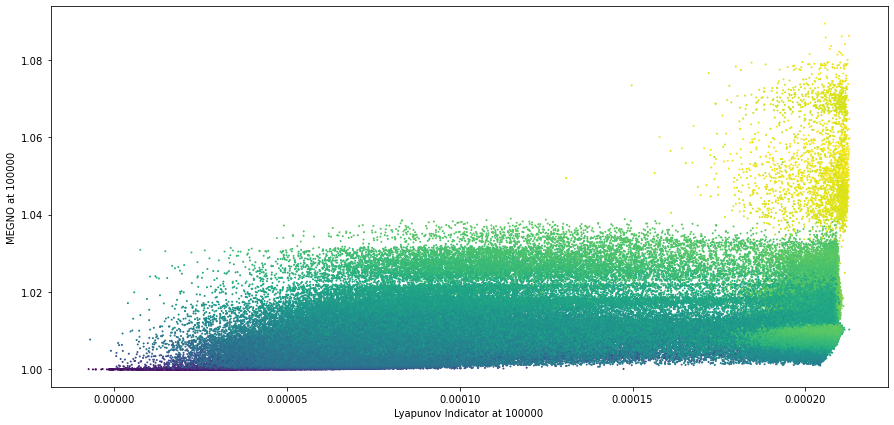

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t2].to_numpy(),
    (megno[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t2}")
ax.set_ylabel(f"MEGNO at {t2}")

## 1.2 - Visualizing convergence for the various Dynamic indicators

Text(0, 0.5, 'Lyapunov Indicator at 100000')

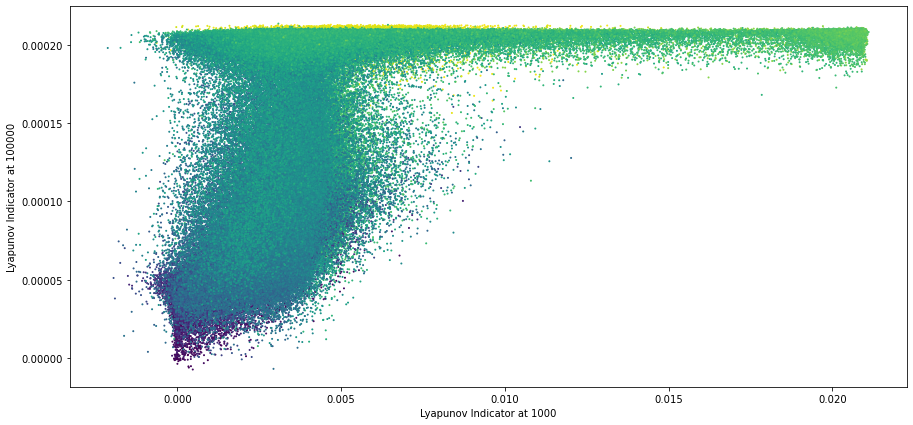

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov[t1].to_numpy(),
    lyapunov[t2].to_numpy(),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"Lyapunov Indicator at {t2}")

Text(0, 0.5, 'Lyapunov Indicator at 100000')

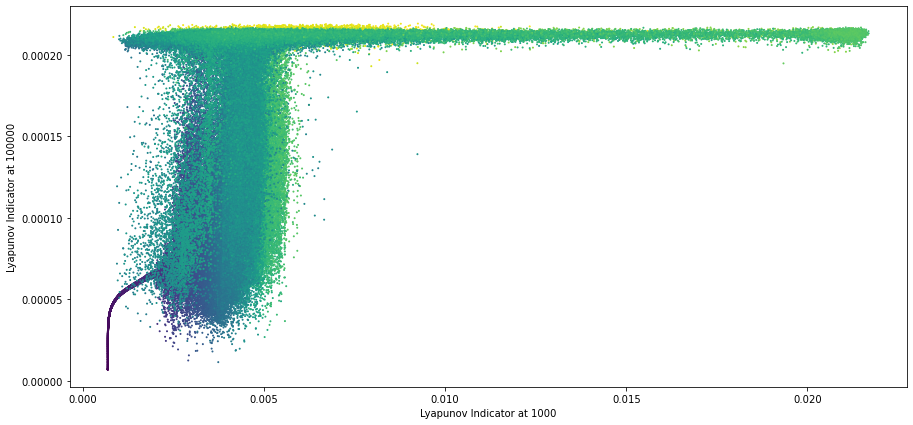

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov_multi[t1].to_numpy(),
    lyapunov_multi[t2].to_numpy(),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Lyapunov Indicator at {t1}")
ax.set_ylabel(f"Lyapunov Indicator at {t2}")

/tmp/ipykernel_25866/3792515338.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[t1].to_numpy()),
/tmp/ipykernel_25866/3792515338.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(reverse[t2].to_numpy()),


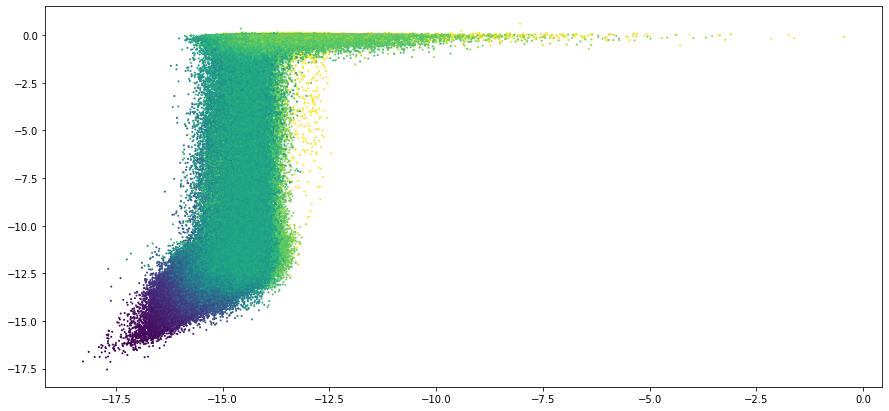

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    np.log10(reverse[t1].to_numpy()),
    np.log10(reverse[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"Reversibility Indicator at {t1}")
ax.set_ylabel(f"Reversibility Indicator at {t2}")


Text(0, 0.5, 'SALI at 100000')

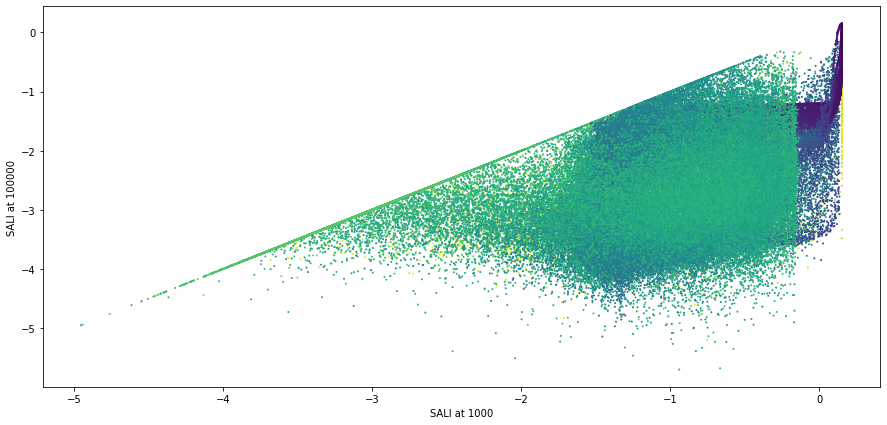

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    np.log10(sali[t1].to_numpy()),
    np.log10(sali[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"SALI at {t1}")
ax.set_ylabel(f"SALI at {t2}")

Text(0, 0.5, 'GALI at 100000')

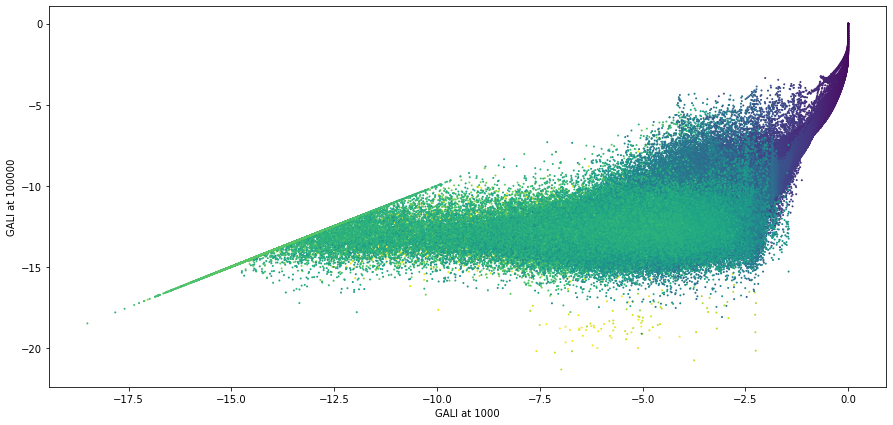

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    np.log10(gali[t1].to_numpy()),
    np.log10(gali[t2].to_numpy()),
    s=1,
    c=colors_radius,
)

ax.set_xlabel(f"GALI at {t1}")
ax.set_ylabel(f"GALI at {t2}")

## 1.3 - Marking down the line and operating with the classification: how to get the best accuracy?

In [41]:
dm.classify_with_data(lyapunov[t1], np.log10(reverse[t1]), 0.015, -10, stable_if_higher=True)

{'tp': 26325,
 'fp': 81318,
 'fn': 32,
 'tn': 328358,
 'total': 436033,
 'accuracy': 0.8134315521990308,
 'precision': 0.2445584013823472,
 'recall': 0.9987859012785977}

## 1.4 - What happens if we perform an averaging convolution?

In [103]:
lyapunov_convolve = dm.apply_convolution_to_dataset(lyapunov, 4)[0]
lyapunov_multi_convolve = dm.apply_convolution_to_dataset(lyapunov_multi, 4)[0]
reverse_convolve = dm.apply_convolution_to_dataset(reverse, 4)[0]
sali_convolve = dm.apply_convolution_to_dataset(sali, 4)[0]
gali_convolve = dm.apply_convolution_to_dataset(gali, 4)[0]
megno_convolve = dm.apply_convolution_to_dataset(megno, 4)[0]


100%|██████████| 71/71 [00:06<00:00, 10.63it/s]


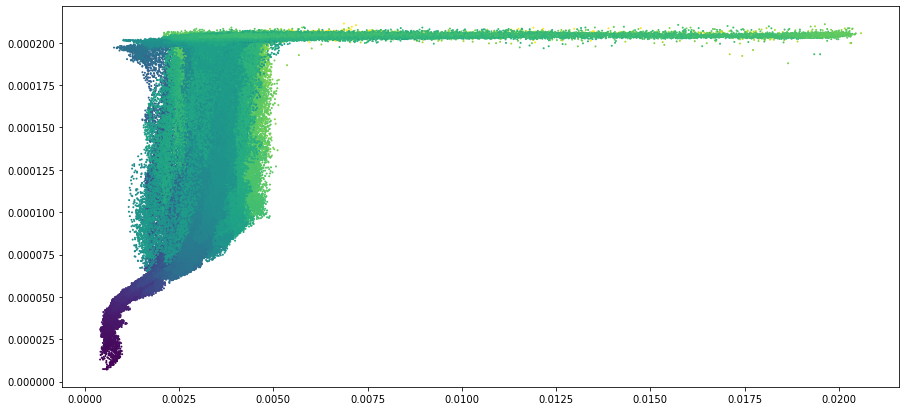

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(
    lyapunov_convolve[t1].to_numpy(),
    lyapunov_convolve[t2].to_numpy(),
    s=1,
    c=colors_radius,
)
